# Questão 1 - Regressão Linear

Previsão do preço dos imóveis na região de King County, EUA.


## Origem dos Dados

O dataset "House Sales in King County, USA" contém informações sobre vendas de casas no condado de King, Washington, EUA, incluindo Seattle. Ele abrange o período de maio de 2014 a maio de 2015.

House Sales in King County, USA
https://www.kaggle.com/datasets/harlfoxem/housesalesprediction

In [1]:
# !pip install -r ../requirements.txt --upgrade

## Imports

In [2]:
import os
import random
import sys
import warnings

from datetime import date
from pathlib import Path


warnings.filterwarnings('ignore')
PROJECT_PATH = os.path.abspath('..')
sys.path.append(PROJECT_PATH)



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
import shap
import tqdm
import xgboost



from IPython.display import display, Markdown
from imblearn.over_sampling import (
    BorderlineSMOTE,
    SMOTE,
)
from scipy.stats import t
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from statsmodels.compat import lzip
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Variáveis globais
SEED = 42
dataset_path = Path(PROJECT_PATH) / 'data' / 'kc_house_data.csv'

# sementes
random.seed(SEED)
np.random.seed(SEED)

# configurações
pd.options.display.max_columns = 500
default_figsize = (16, 5)
default_figsize_small = (16, 2.5)
sns.set_theme(style='whitegrid', context='notebook', palette='deep')

# funcoes
def plot_histogram_boxplot(df_, coluna_, descricao_, hue_=None):
    """Plota histograma e boxplot para uma coluna categórica.

    Args:
        df_ (pd.DataFrame): DataFrame com os dados.
        coluna_ (str): Nome da coluna a ser plotada.
        descricao_ (str): Descrição da coluna.
        hue_ (str, optional): Coluna para agrupar os dados. Defaults to None.
    """
    fig, ax = plt.subplots(1, 2, figsize=default_figsize)

    df_counts = df_[coluna_].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    # Subplot 1: histograma por bairro
    plt.subplot(1, 2, 1)
    sns.barplot(x=coluna_, y='Ocorrências', data=df_counts, ax=ax[0], hue=hue_)
    plt.title(f'Ocorrências por {descricao_}', fontsize=13)
    plt.xlabel(coluna_)
    plt.ylabel('Ocorrências')
    plt.xticks(rotation=90)

    # # Subplot 2: Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=coluna_, y='price', data=df_, ax=ax[1], hue=hue_)
    plt.title(f'Boxplot por {descricao_}')
    plt.ylabel('Preço de Venda (R$)')
    plt.xlabel(coluna_)
    plt.xticks(ticks=range(df_counts.shape[0]), labels=df_[coluna_].drop_duplicates().sort_values(), rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_hist_qq_box(df, coluna, descricao):
    """Plota histograma, Q-Q plot e boxplot para uma coluna numérica.

    Args:
        df (pd.DataFrame): DataFrame com os dados.
        coluna (str): Nome da coluna a ser plotada.
        descricao (str): Descrição da coluna.
    """
    plt.figure(figsize=default_figsize)

    # Subplot 1: histograma
    plt.subplot(1, 3, 1)
    sns.histplot(df[coluna], kde=True)
    plt.title('Histograma' , fontsize=13)
    plt.xlabel(descricao)
    plt.ylabel('Ocorrências')

    # Subplot 2: QQ-plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[coluna], dist="norm", plot=plt)
    plt.xticks(ticks=np.arange(-4, 5, 1))
    # girar xaxis
    plt.xticks(rotation=90)
    plt.title('Q-Q plot')
    plt.xlabel('Quartis teóricos')
    plt.ylabel('Quartis amostrais')

    # Subplot 3: Boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[coluna])
    plt.title('Boxplot')
    plt.ylabel(descricao)
    plt.xlabel('')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Teste de Shapiro-Wilk 
    s, p = shapiro(df[coluna])
    print('Shapiro-Wilk para a distribuição original:')
    print('Estatística=%.3f, p=%.3f' % (s, p))
    alpha = 0.05
    if p > alpha:
        print('Amostra parece ser normalmente distribuída (falha em rejeitar H0)')
    else:
        print('Amostra não parece ser normalmente distribuída (rejeita H0)')


def plot_scatter(df, coluna, descricao):
    """Plota um gráfico de dispersão entre a coluna e o preço de venda.

    Args:
        df (pd.DataFrame): DataFrame com os dados.
        coluna (str): Nome da coluna a ser plotada.
        descricao (str): Descrição da coluna.
    """
    fig, axes = plt.subplots(1, 1, figsize=(16, 7.5))

    sns.scatterplot(ax=axes, x=coluna, y='price', data=df, hue=coluna, alpha=0.4, palette='viridis')
    axes.set_title(f'{descricao} vs Preço de Venda')
    axes.legend(loc='upper right', framealpha=0.2, fancybox=True)

    plt.tight_layout()
    plt.show()


def conf_interval(mean, std, n, alpha=0.95):
    h = std * t.ppf((1 + alpha) / 2, n - 1)
    return mean - h, mean + h

In [3]:
df = pd.read_csv(dataset_path)

In [4]:
df.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0      5650     1.0           0     0          3      7        1180   
1      7242     2.0           0     0          3      7        2170   
2     10000     1.0           0     0          3      6         770   
3      5000     1.0           0     0          5      7        1050   
4      8080     1.0           0     0          3      8        1680   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1955             0    98178  47.5112 -122.257   
1            400      1951          1991    98125  47.7210 -122.319   
2              0      1933             0    98028  47.7379 -122.233   
3            910      1965             0    98136  47.5208 -122.393   
4              0      1987             0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503

## Análise Exploratória

### Informações Gerais

In [5]:
total__registros = df.shape[0]
total_colunas = df.shape[1]
total_nulos = df.isna().sum().to_frame()
total_nulos = total_nulos.rename(columns={0:'Nulos'})
total_nulos.index.name = 'Coluna'

# escrever uma pequena análise a respeito 
display(Markdown(f"""
**Total de registros**: {total__registros} \\
**Total de colunas**: {total_colunas} \\
Nenhuma coluna possui valores nulos.
"""))


display(total_nulos)



**Total de registros**: 21613 \
**Total de colunas**: 21 \
Nenhuma coluna possui valores nulos.


Nulos
Coluna              
id                 0
date               0
price              0
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
view               0
condition          0
grade              0
sqft_above         0
sqft_basement      0
yr_built           0
yr_renovated       0
zipcode            0
lat                0
long               0
sqft_living15      0
sqft_lot15         0

As colunas id e date não serão utilizadas na análise, pois não são relevantes para a previsão do preço dos imóveis.

In [6]:
df = df.drop(columns=['id', 'date'], errors='ignore')
df.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0         3       1.00         1180      5650     1.0           0   
1  538000.0         3       2.25         2570      7242     2.0           0   
2  180000.0         2       1.00          770     10000     1.0           0   
3  604000.0         4       3.00         1960      5000     1.0           0   
4  510000.0         3       2.00         1680      8080     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      7        2170            400      1951          1991   
2     0          3      6         770              0      1933             0   
3     0          5      7        1050            910      1965             0   
4     0          3      8        1680              0      1987             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98125  47.7210 -122.319           1690        7639  
2    98028  47.7379 -122.233           2720        8062  
3    98136  47.5208 -122.393           1360        5000  
4    98074  47.6168 -122.045           1800        7503

### price

O preço de venda da casa.

In [7]:
df_price = df['price'].describe().to_frame()
nulos = df['price'].isna().sum()

# exibir a d3escritiva e nulos
display(df_price)

# escrever uma pequena análise a respeito 
display(Markdown(f"""
O preço de venda das propriedades varia de R\\${df['price'].min()} a R\\${df['price'].max()}, com uma média de R\\${df['price'].mean():,.2f} e mediana de R\\${df['price'].median():,.2f}.
O desvio padrão é de R\\${df['price'].std():,.2f}.
"""))


price
count  2.161300e+04
mean   5.400881e+05
std    3.671272e+05
min    7.500000e+04
25%    3.219500e+05
50%    4.500000e+05
75%    6.450000e+05
max    7.700000e+06


O preço de venda das propriedades varia de R\$75000.0 a R\$7700000.0, com uma média de R\$540,088.14 e mediana de R\$450,000.00.
O desvio padrão é de R\$367,127.20.


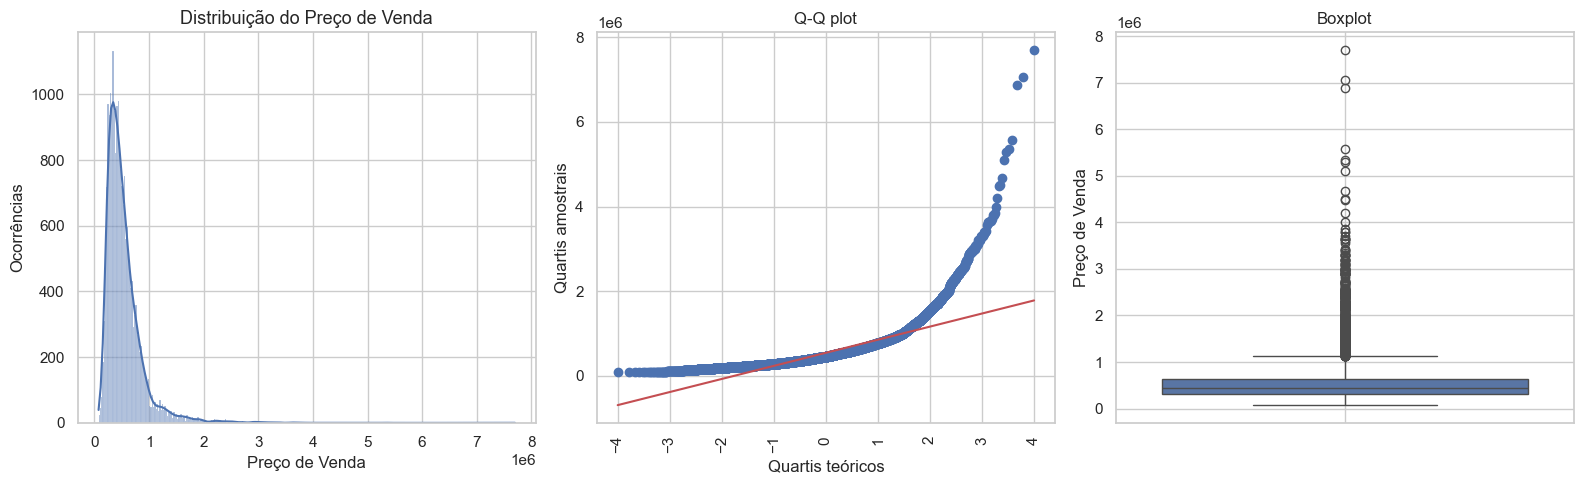

In [8]:
coluna = 'price'
descricao = 'Preço de Venda'

plt.figure(figsize=default_figsize)

# Subplot 1: histograma
plt.subplot(1, 3, 1)
sns.histplot(df[coluna], kde=True)
plt.title(r'Distribuição do Preço de Venda', fontsize=13)
plt.xlabel(descricao)
plt.ylabel('Ocorrências')

# Subplot 2: QQ-plot
plt.subplot(1, 3, 2)
stats.probplot(df[coluna], dist="norm", plot=plt)
plt.xticks(ticks=np.arange(-4, 5, 1))
# girar xaxis
plt.xticks(rotation=90)
plt.title('Q-Q plot')
plt.xlabel('Quartis teóricos')
plt.ylabel('Quartis amostrais')

# Subplot 3: Boxplot
plt.subplot(1, 3, 3)
sns.boxplot(y=df[coluna])
plt.title('Boxplot')
plt.ylabel(descricao)
plt.xlabel('')
plt.grid(True)

plt.tight_layout()
plt.show()

Presença de outliers.

### bedrooms

Número de quartos na casa.


**Tipo de Variável**: Numérica, discreta



**Ocorrências por Número de Quartos**


bedrooms  Ocorrências
0          3         9824
1          4         6882
2          2         2760
3          5         1601
4          6          272
5          1          199
6          7           38
7          0           13
8          8           13
9          9            6
10        10            3
11        11            1
12        33            1

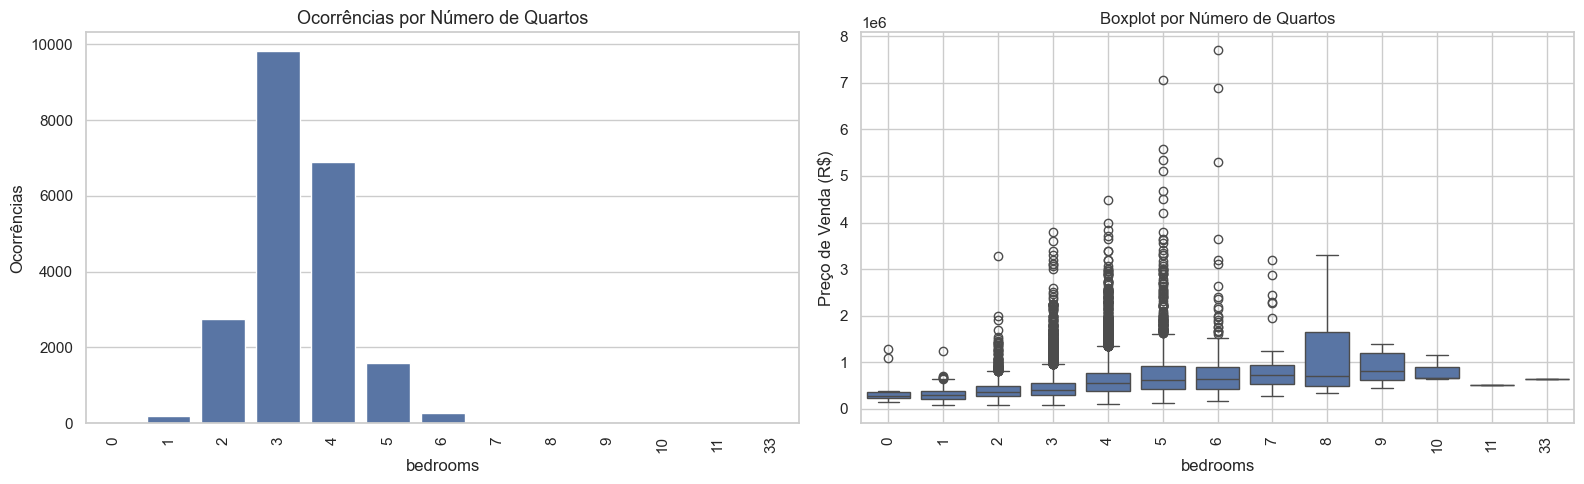

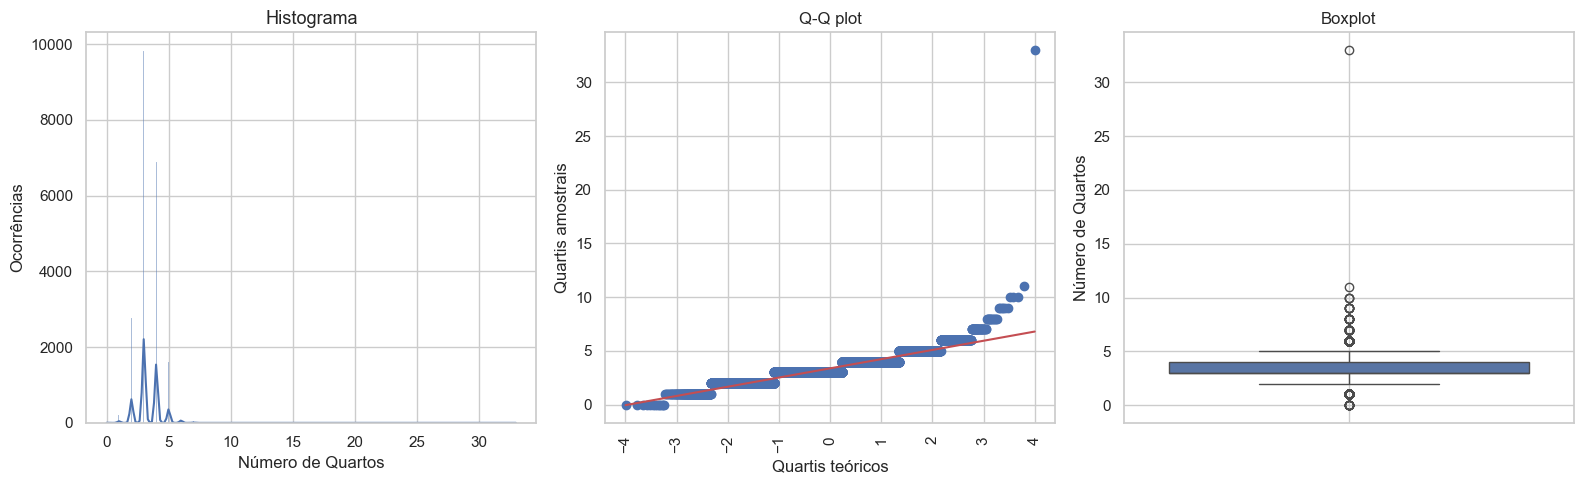

Shapiro-Wilk para a distribuição original:
Estatística=0.849, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


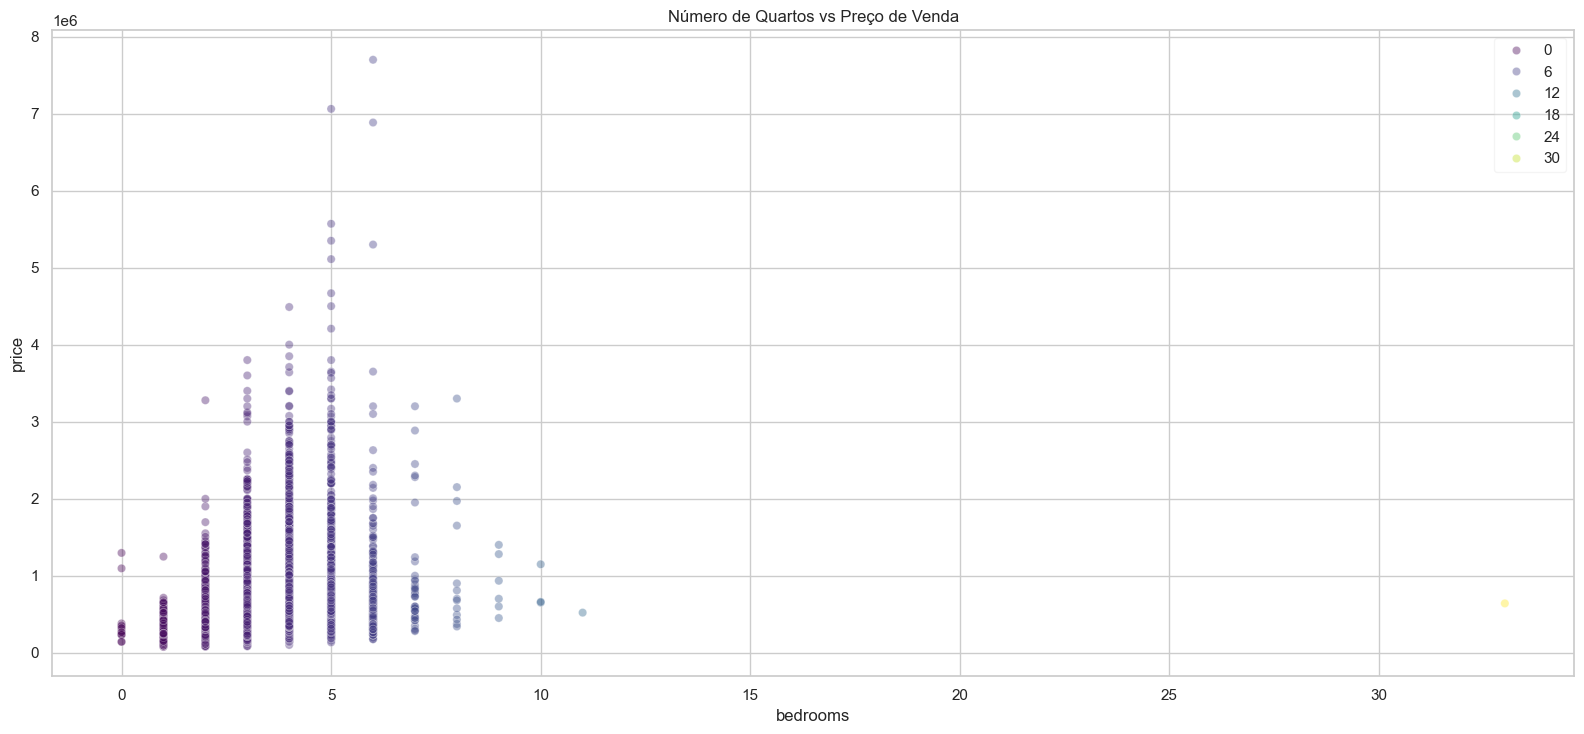

In [9]:
coluna = 'bedrooms'
descricao = 'Número de Quartos'
hue = None

display(Markdown(f"""
**Tipo de Variável**: Numérica, discreta
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
display(df_counts)

plot_histogram_boxplot(df, coluna, descricao, hue)

plot_hist_qq_box(df, coluna, descricao)

plot_scatter(df, coluna, descricao)

### bathrooms

Número de banheiros na casa (pode incluir casas de banho).


**Tipo de Variável**: Numérica, discreta



**Ocorrências por Número de Banheiros**


bathrooms  Ocorrências
0        2.50         5380
1        1.00         3852
2        1.75         3048
3        2.25         2047
4        2.00         1930
5        1.50         1446
6        2.75         1185
7        3.00          753
8        3.50          731
9        3.25          589
10       3.75          155
11       4.00          136
12       4.50          100
13       4.25           79
14       0.75           72
15       4.75           23
16       5.00           21
17       5.25           13
18       0.00           10
19       5.50           10
20       1.25            9
21       6.00            6
22       0.50            4
23       5.75            4
24       6.75            2
25       8.00            2
26       6.50            2
27       6.25            2
28       7.75            1
29       7.50            1

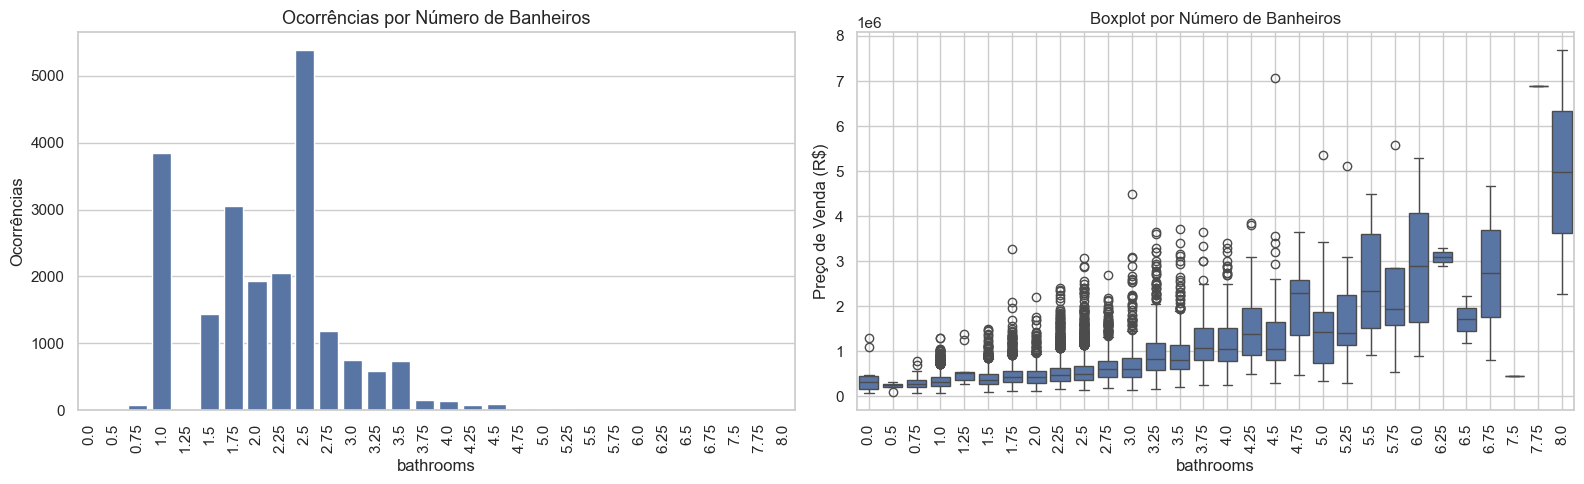

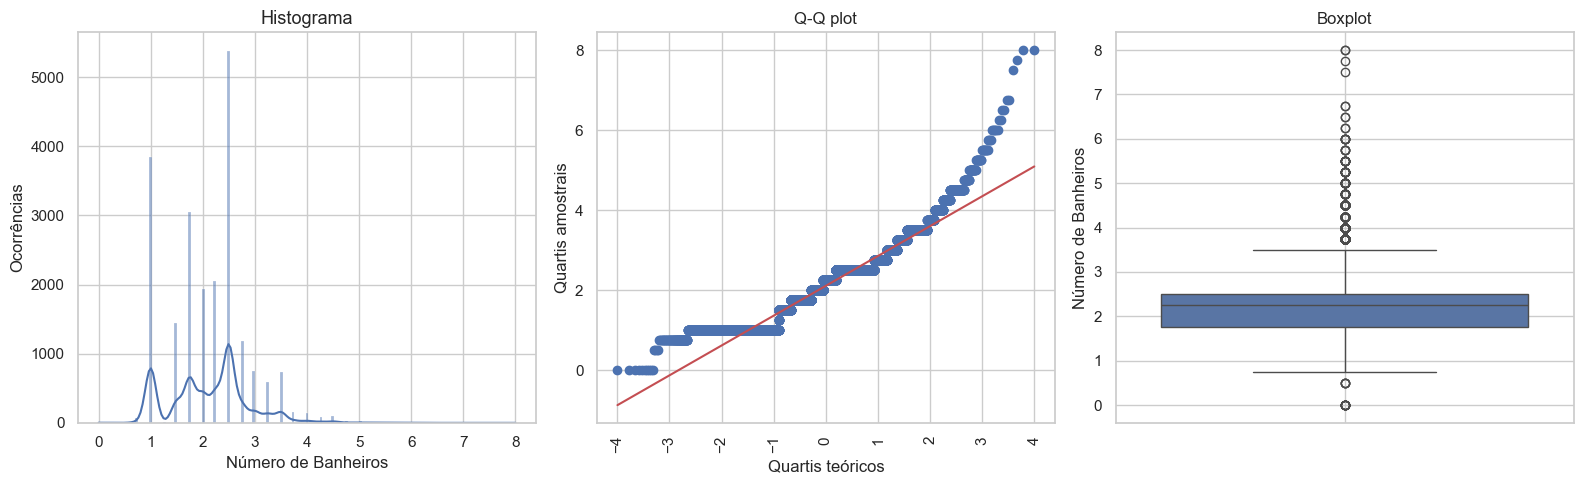

Shapiro-Wilk para a distribuição original:
Estatística=0.937, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


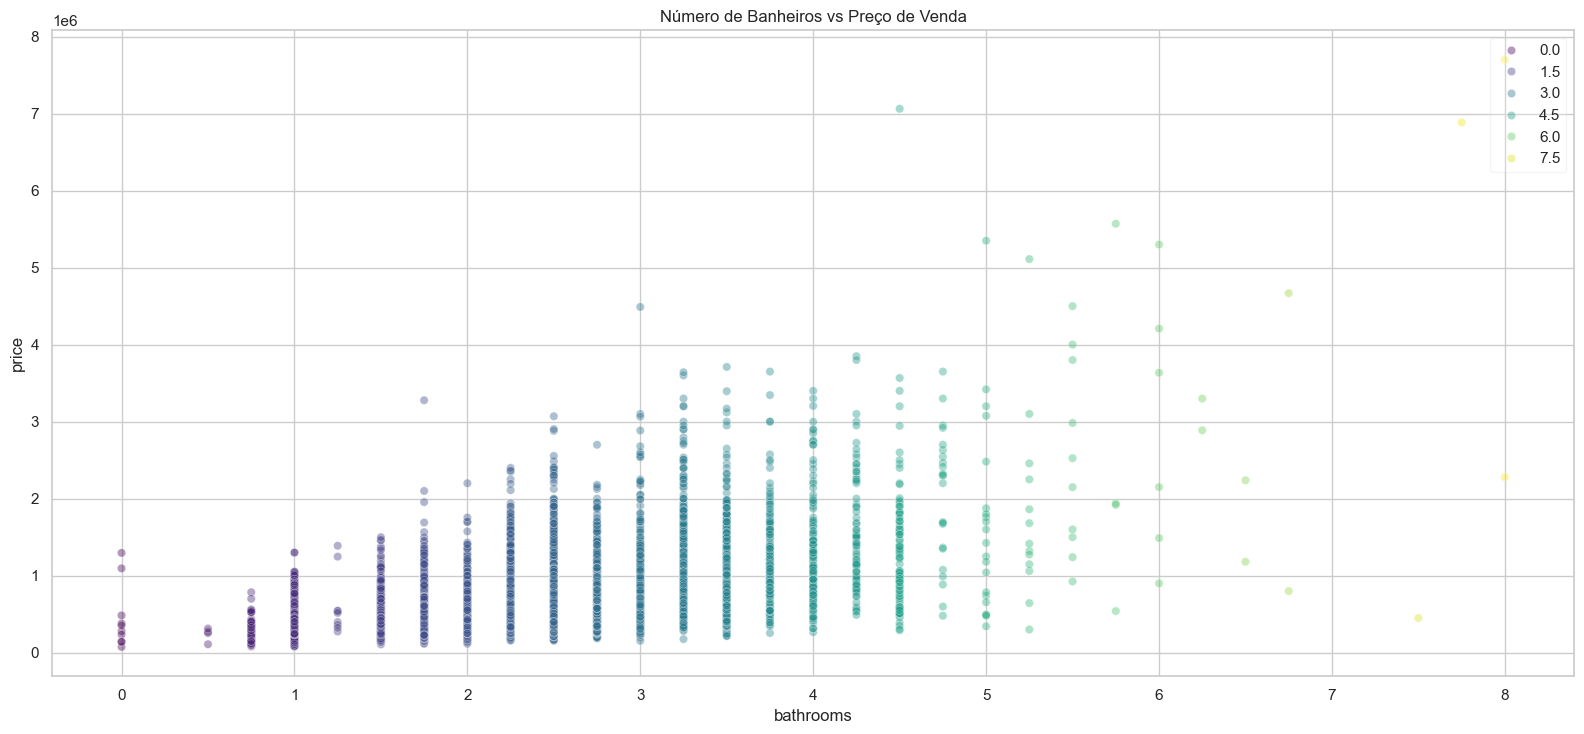

In [10]:
coluna = 'bathrooms'
descricao = 'Número de Banheiros'
hue = None

display(Markdown(f"""
**Tipo de Variável**: Numérica, discreta
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
display(df_counts)

plot_histogram_boxplot(df, coluna, descricao, hue)

plot_hist_qq_box(df, coluna, descricao)

plot_scatter(df, coluna, descricao)

### sqft_living

Área útil da casa em pés quadrados.


**Tipo de Variável**: Numérica, contínua



**Ocorrências por Área Útil (ft2)**


sqft_living
count  21613.000000
mean    2079.899736
std      918.440897
min      290.000000
25%     1427.000000
50%     1910.000000
75%     2550.000000
max    13540.000000

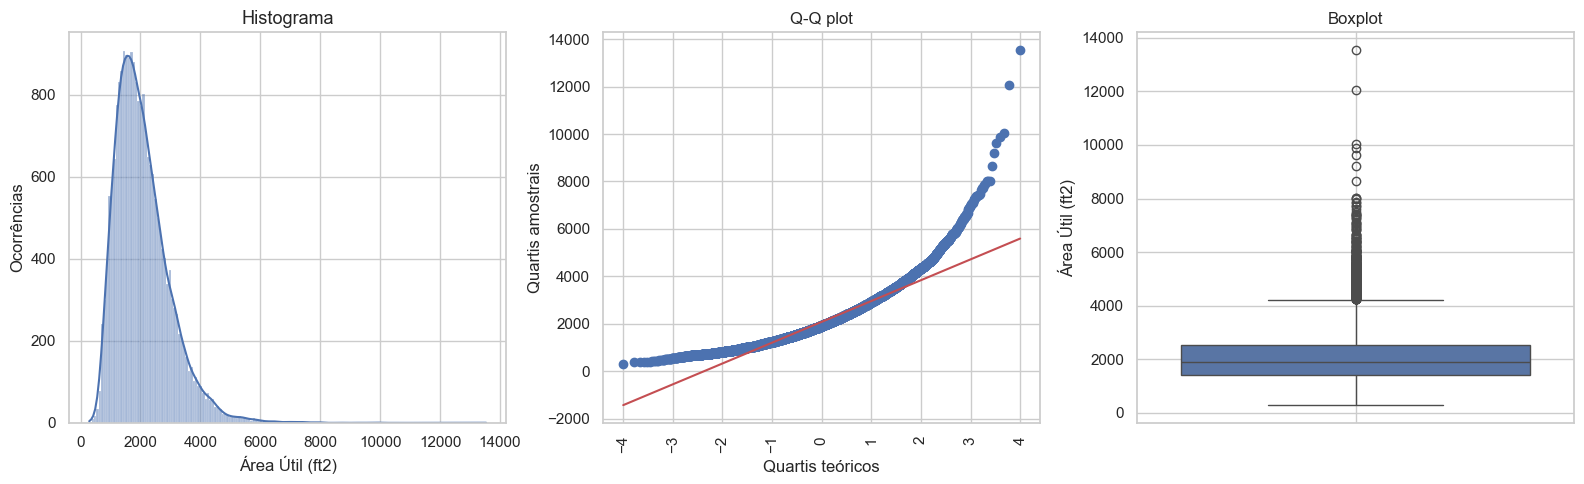

Shapiro-Wilk para a distribuição original:
Estatística=0.915, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


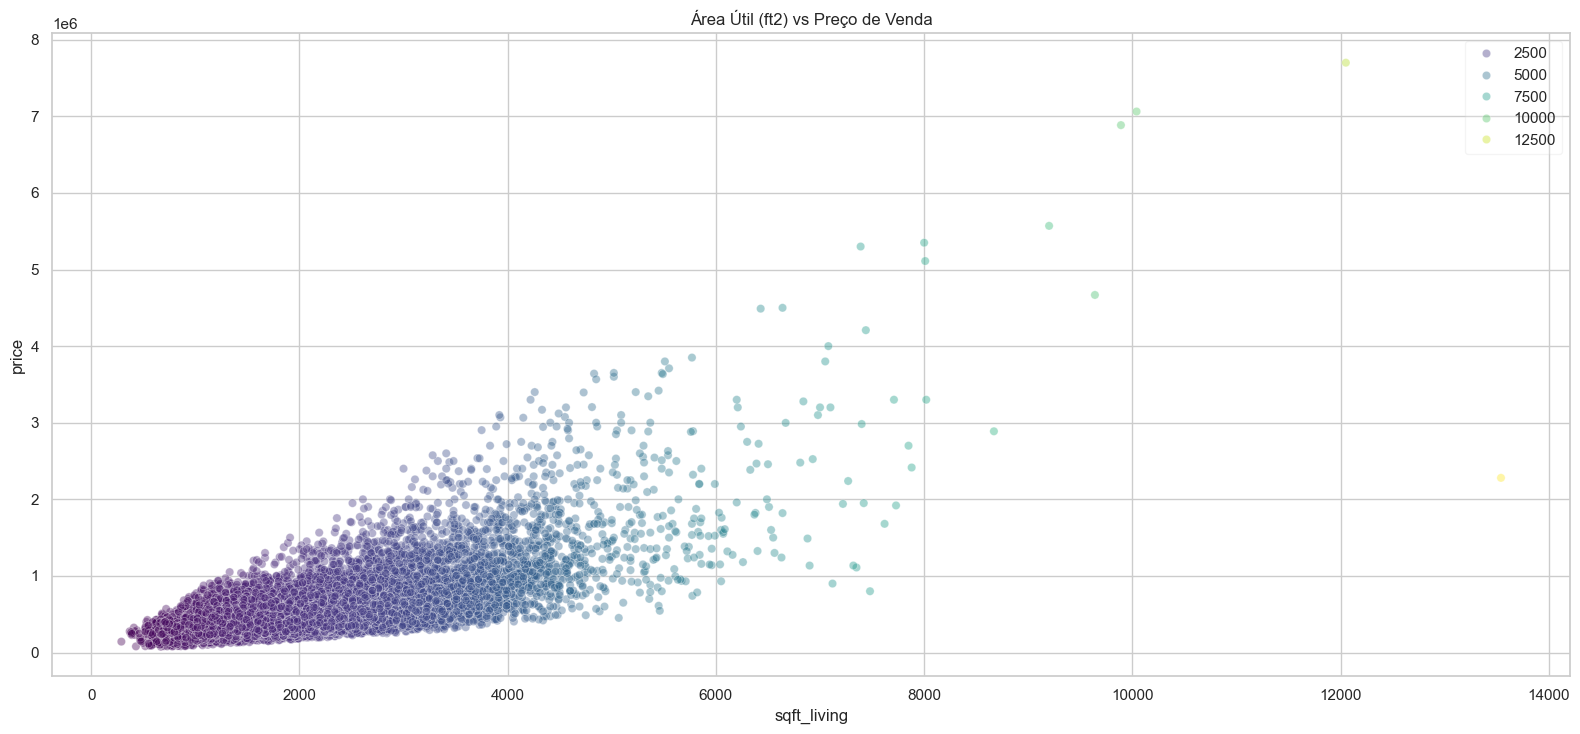

In [11]:
coluna = 'sqft_living'
descricao = 'Área Útil (ft2)'
hue = None
tipo_variavel = 'Numérica, contínua'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### sqft_lot

Área total do terreno em pés quadrados.


**Tipo de Variável**: Numérica, contínua



**Ocorrências por Área do terreno (ft2)**


sqft_lot
count  2.161300e+04
mean   1.510697e+04
std    4.142051e+04
min    5.200000e+02
25%    5.040000e+03
50%    7.618000e+03
75%    1.068800e+04
max    1.651359e+06

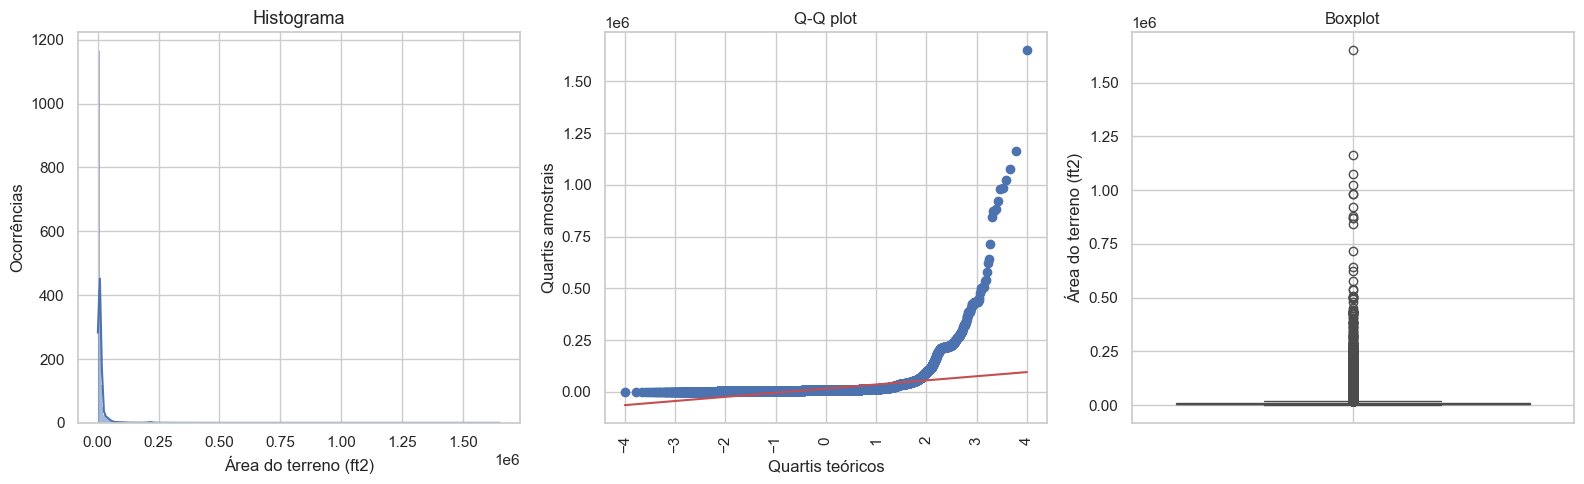

Shapiro-Wilk para a distribuição original:
Estatística=0.233, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


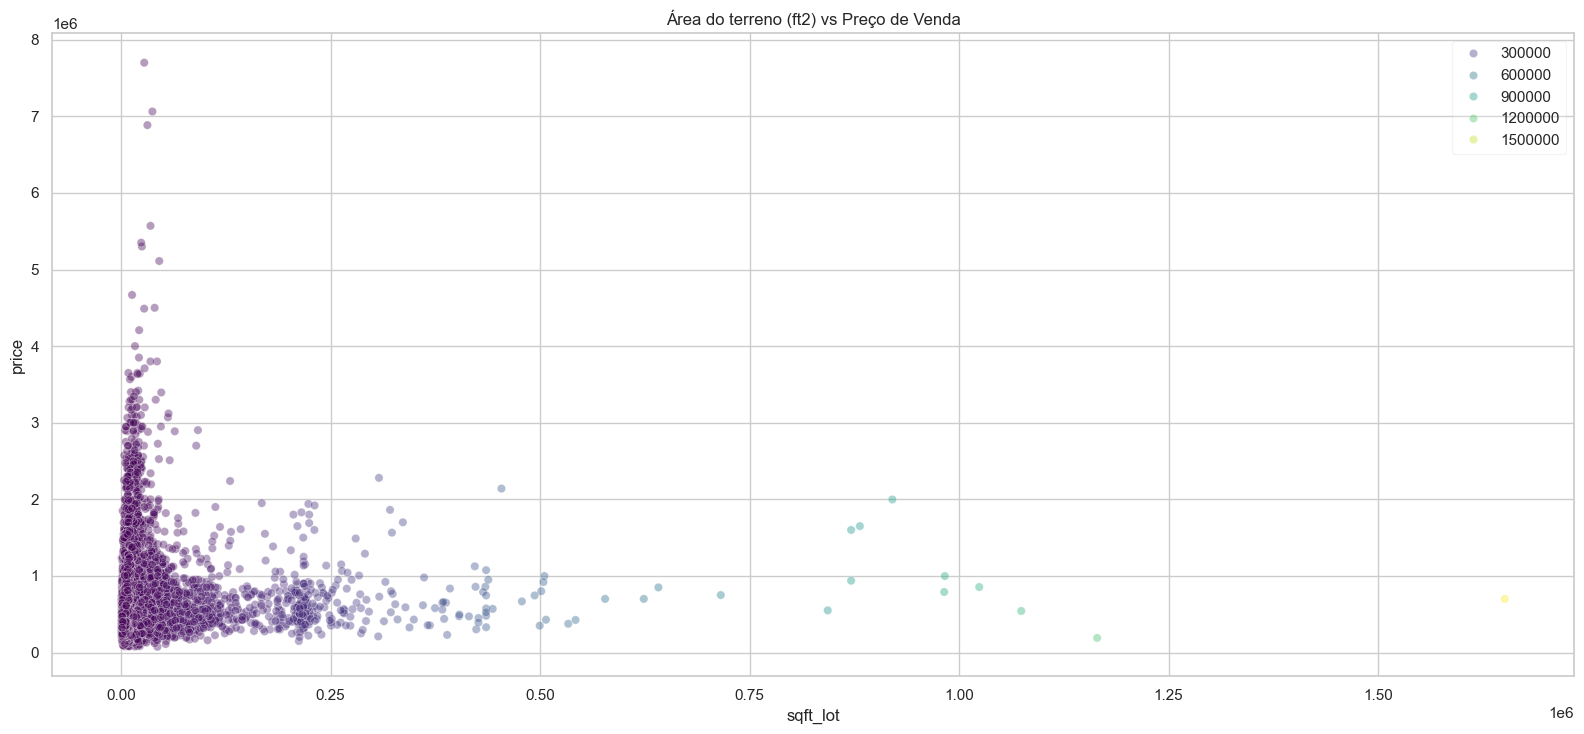

In [12]:
coluna = 'sqft_lot'
descricao = 'Área do terreno (ft2)'
hue = None
tipo_variavel = 'Numérica, contínua'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### floors

Número de andares da casa.


**Tipo de Variável**: Numérica, discreta



**Ocorrências por Número de andares**


floors  Ocorrências
0     1.0        10680
1     2.0         8241
2     1.5         1910
3     3.0          613
4     2.5          161
5     3.5            8

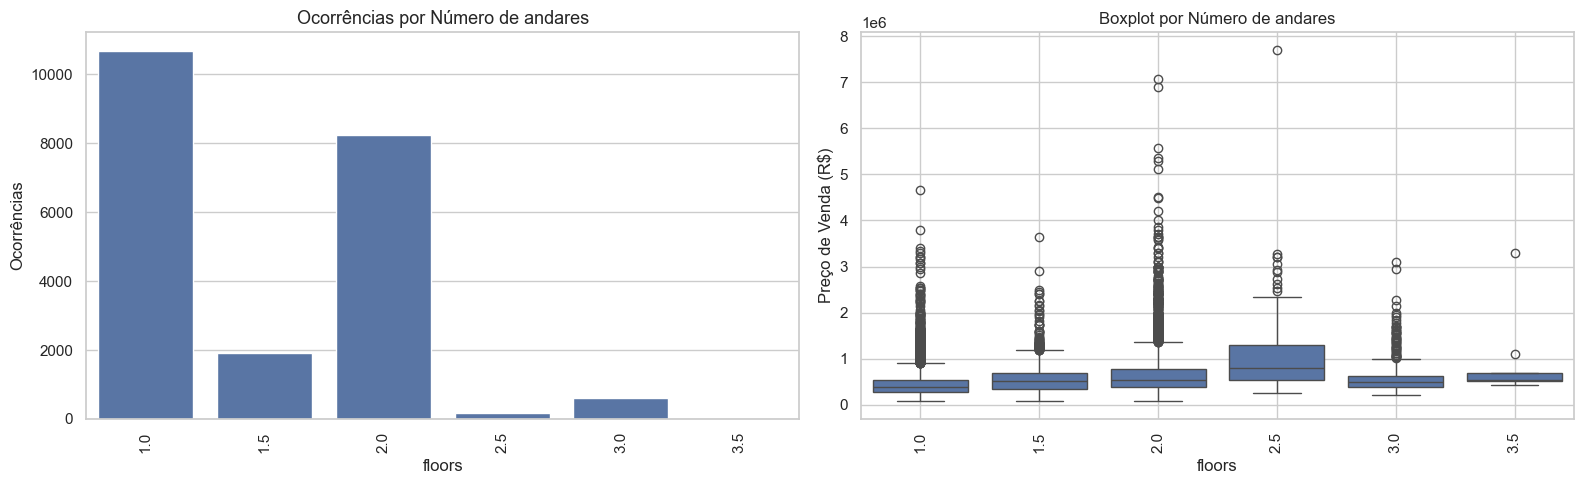

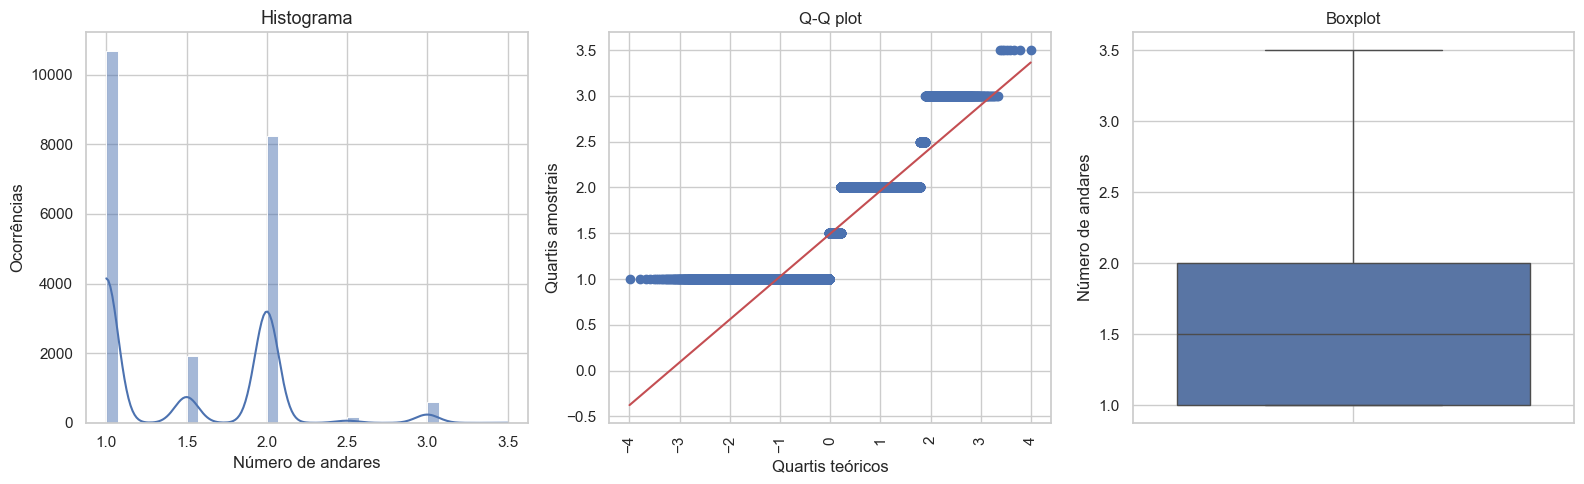

Shapiro-Wilk para a distribuição original:
Estatística=0.751, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


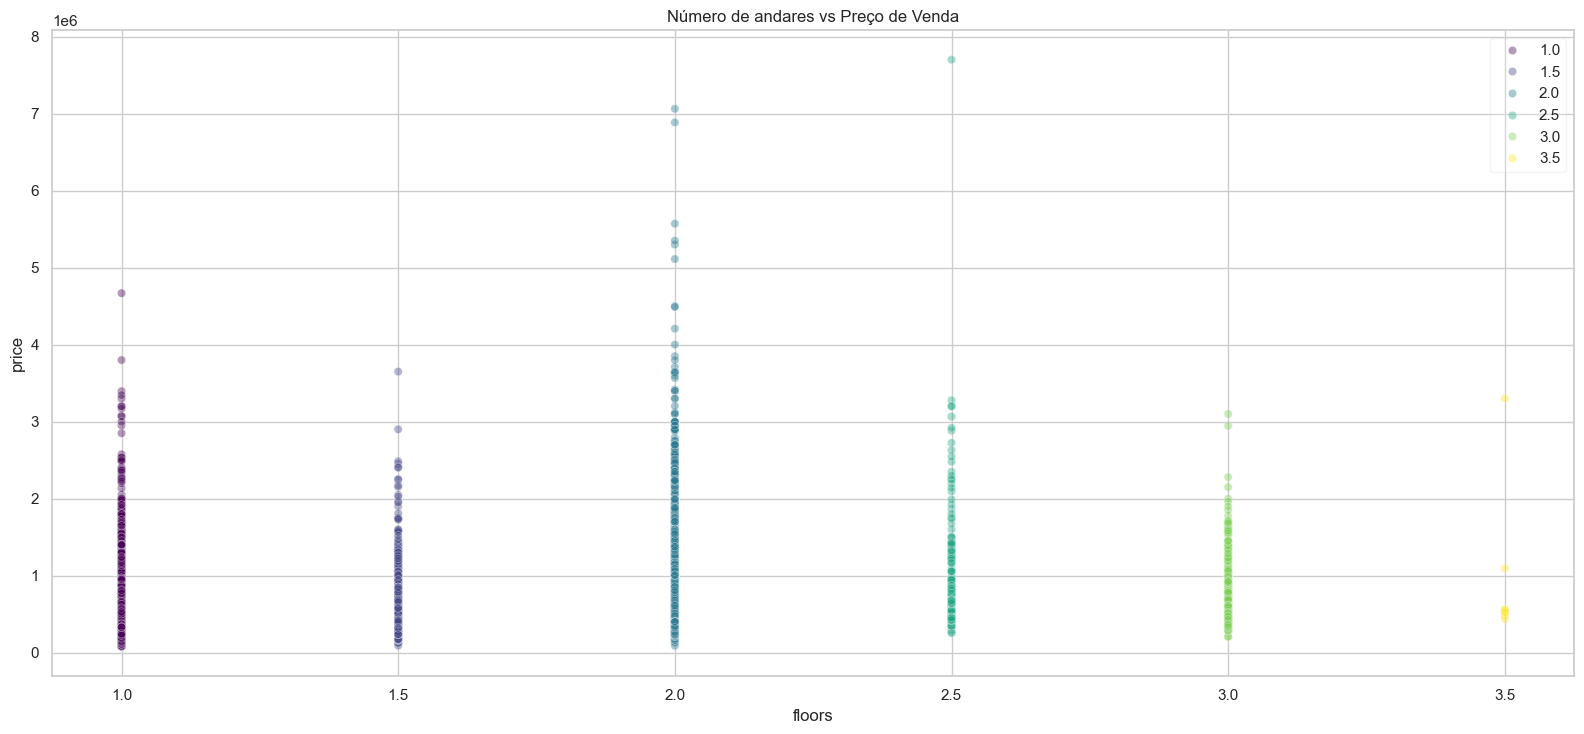

In [13]:
coluna = 'floors'
descricao = 'Número de andares'
hue = None
tipo_variavel = 'Numérica, discreta'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### waterfront

Uma variável binária indicando se a casa tem vista para a água (1) ou não (0).


**Tipo de Variável**: Numérica, discreta



**Ocorrências por Vista para o mar**


waterfront  Ocorrências
0           0        21450
1           1          163

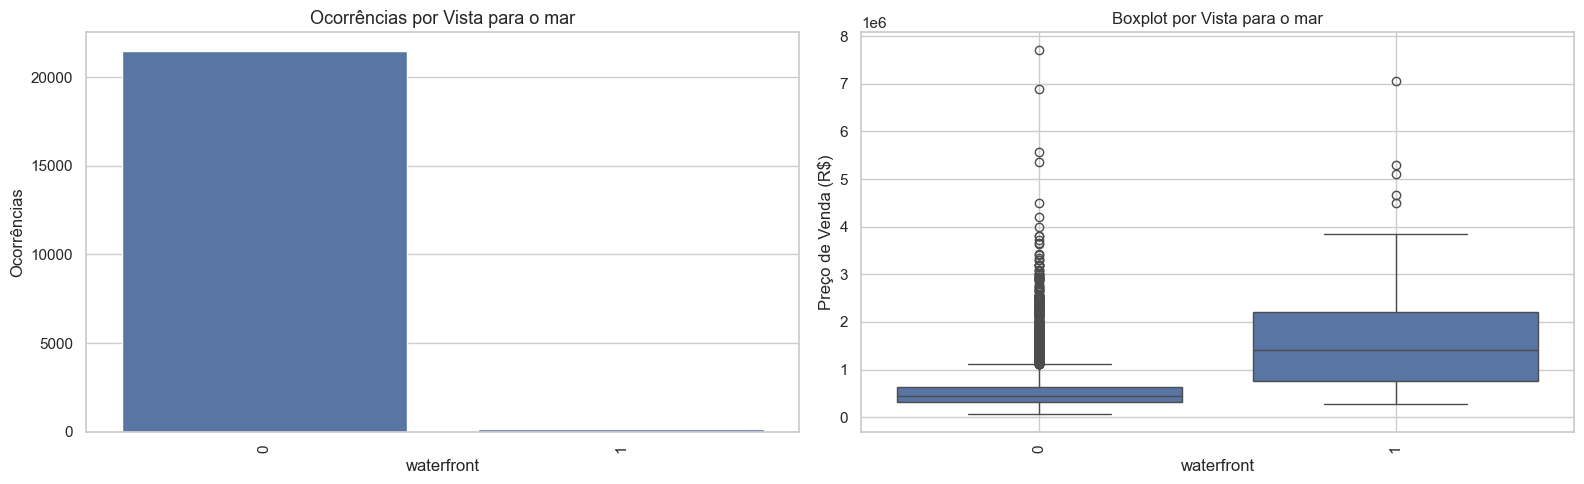

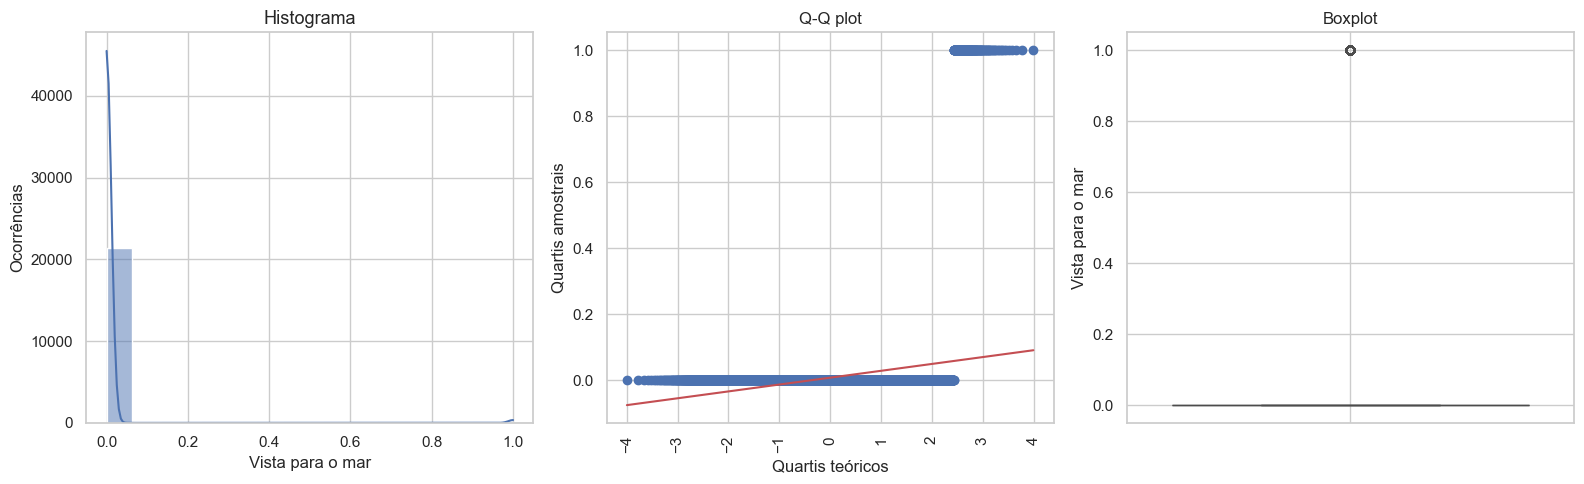

Shapiro-Wilk para a distribuição original:
Estatística=0.058, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


In [14]:
coluna = 'waterfront'
descricao = 'Vista para o mar'
hue = None
tipo_variavel = 'Numérica, discreta'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### view

Um índice de 0 a 4 indicando a qualidade da vista da casa.


**Tipo de Variável**: Numérica, discreta



**Ocorrências por Vista**


view  Ocorrências
0     0        19489
1     2          963
2     3          510
3     1          332
4     4          319

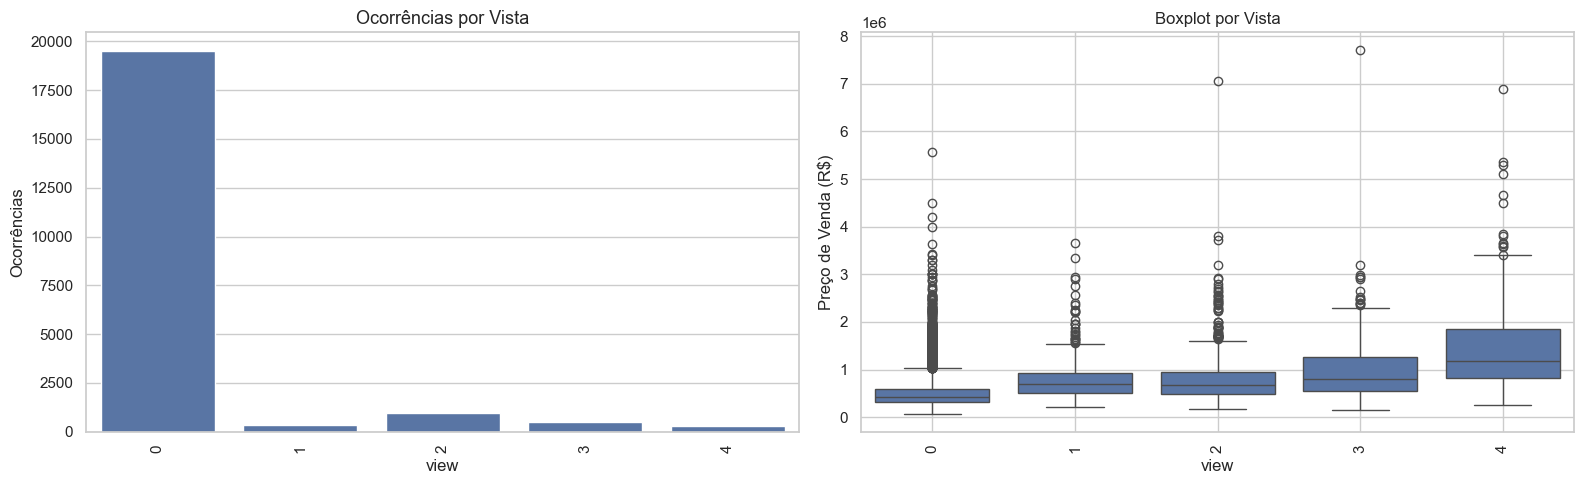

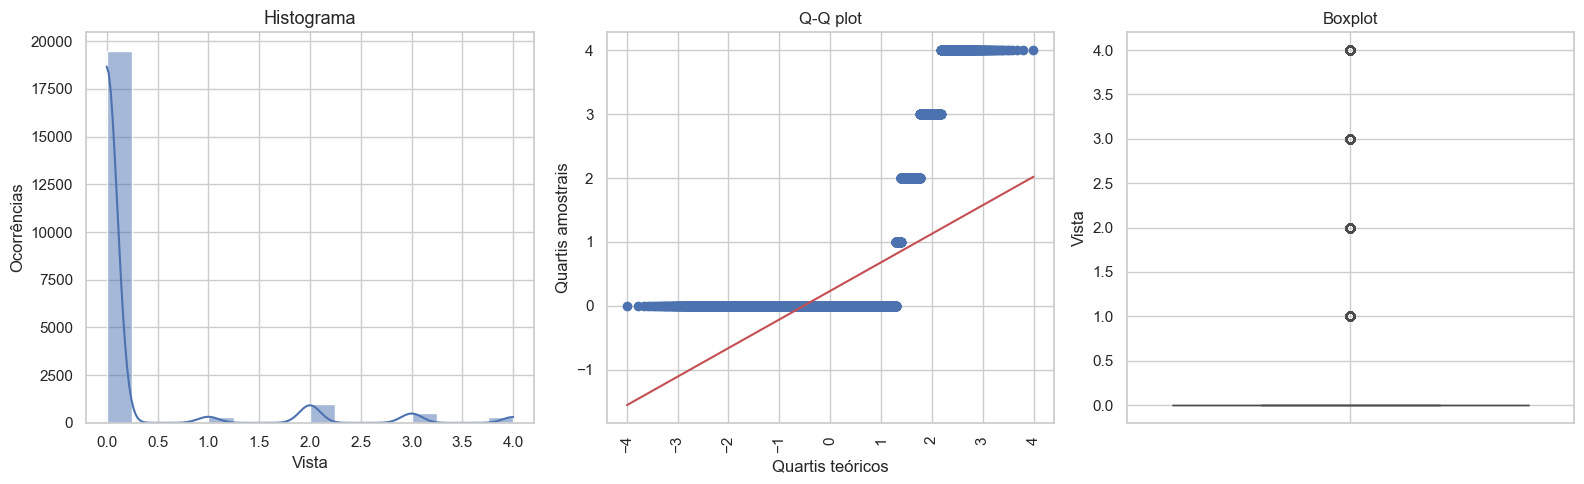

Shapiro-Wilk para a distribuição original:
Estatística=0.340, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


In [15]:
coluna = 'view'
descricao = 'Vista'
hue = None
tipo_variavel = 'Numérica, discreta'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### condition
 
Um índice de 1 a 5 indicando a condição da casa.


**Tipo de Variável**: Numérica, discreta



**Ocorrências por Condição da Casa**


condition  Ocorrências
0          3        14031
1          4         5679
2          5         1701
3          2          172
4          1           30

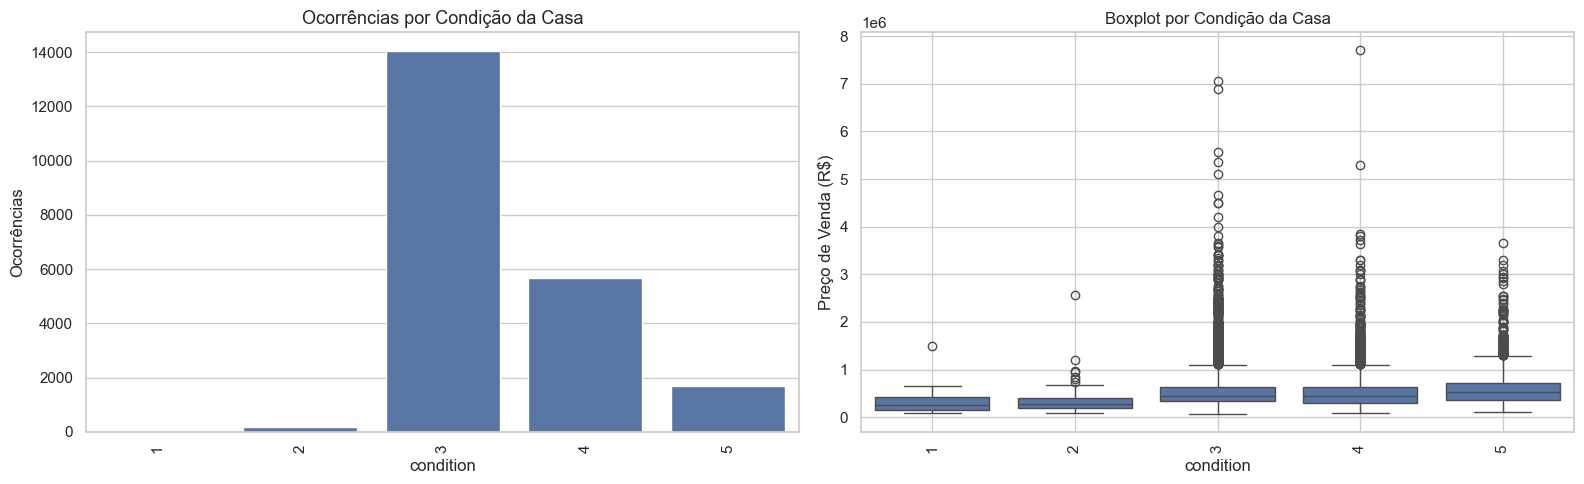

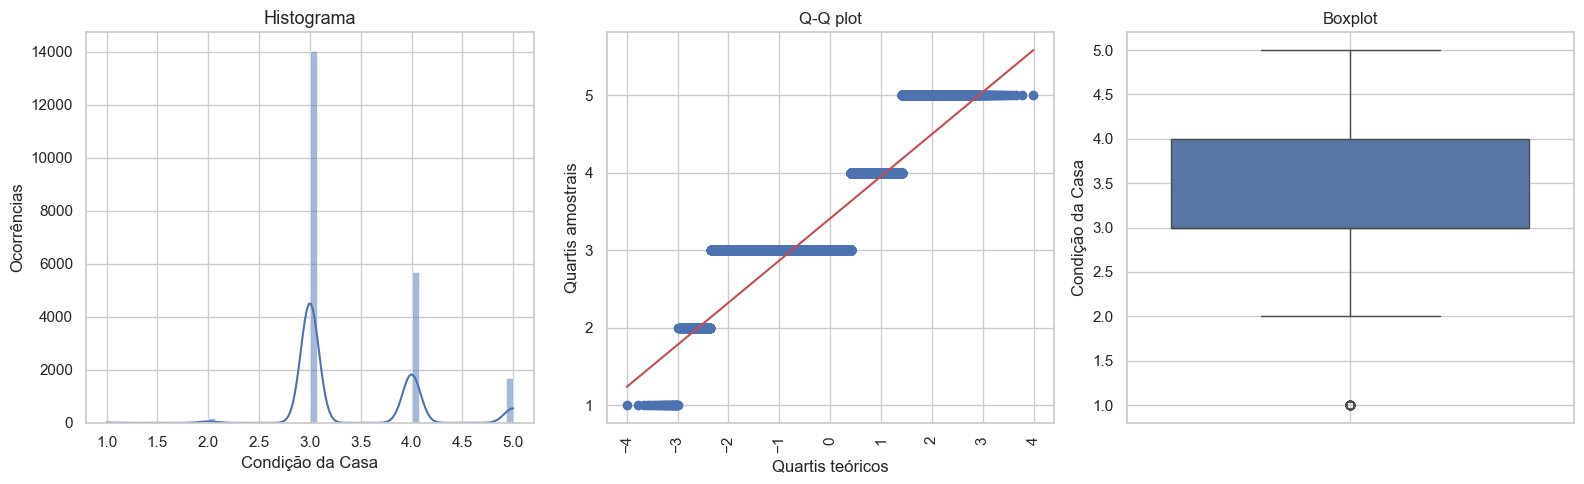

Shapiro-Wilk para a distribuição original:
Estatística=0.698, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


In [16]:
coluna = 'condition'
descricao = 'Condição da Casa'
hue = None
tipo_variavel = 'Numérica, discreta'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### grade

Um índice de 1 a 13, onde 1-3 indica construção e design de baixa qualidade, 7 é qualidade média e 11-13 indica construção e design de alta qualidade.


**Tipo de Variável**: Numérica, discreta



**Ocorrências por Qualidade da Contrução**


grade  Ocorrências
0       7         8981
1       8         6068
2       9         2615
3       6         2038
4      10         1134
5      11          399
6       5          242
7      12           90
8       4           29
9      13           13
10      3            3
11      1            1

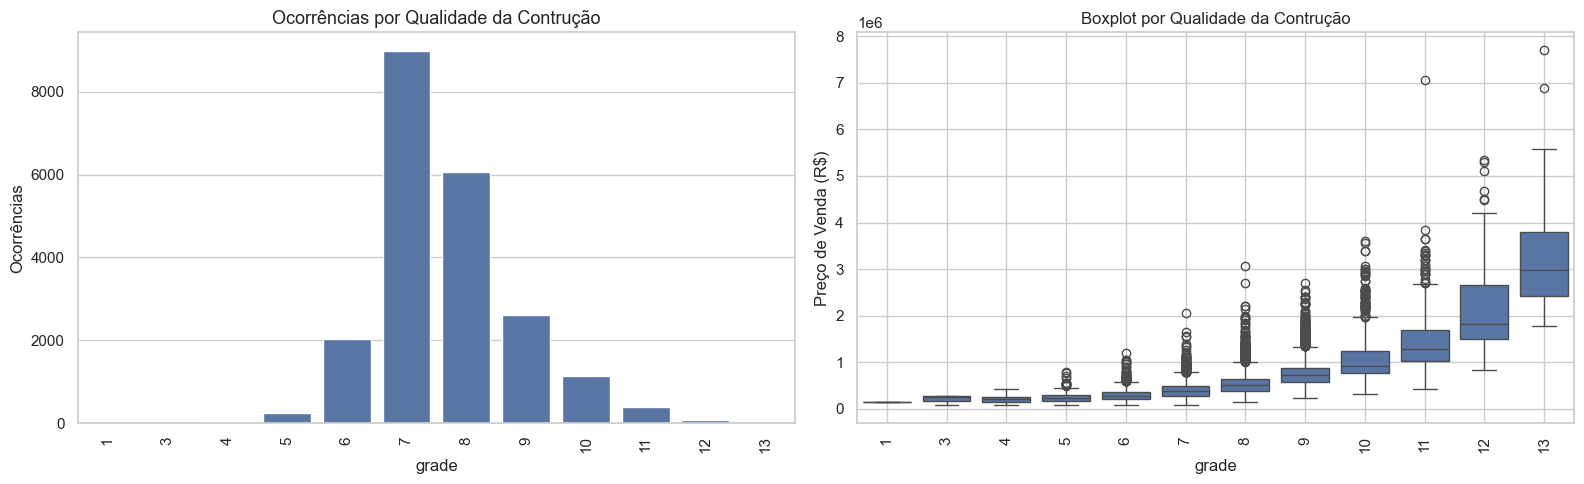

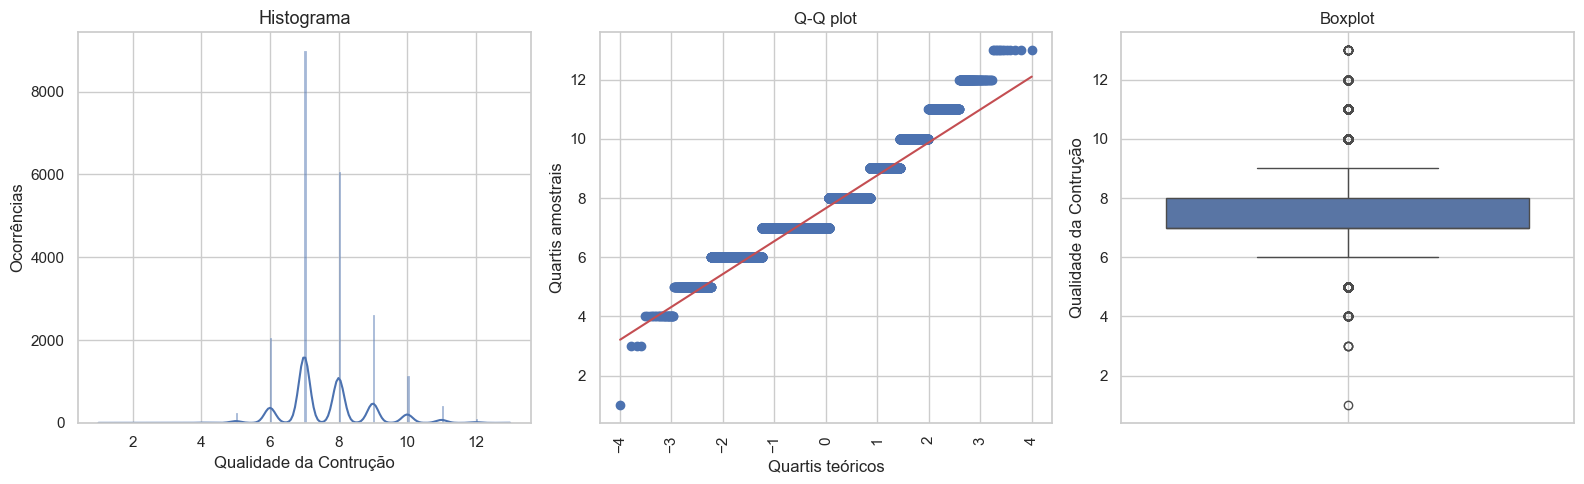

Shapiro-Wilk para a distribuição original:
Estatística=0.895, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


In [17]:
coluna = 'grade'
descricao = 'Qualidade da Contrução'
hue = None
tipo_variavel = 'Numérica, discreta'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### sqft_above

Área da casa em pés quadrados acima do nível do solo.


**Tipo de Variável**: Numérica, contínua



**Ocorrências por Área da Casa (ft2)**


sqft_above
count  21613.000000
mean    1788.390691
std      828.090978
min      290.000000
25%     1190.000000
50%     1560.000000
75%     2210.000000
max     9410.000000

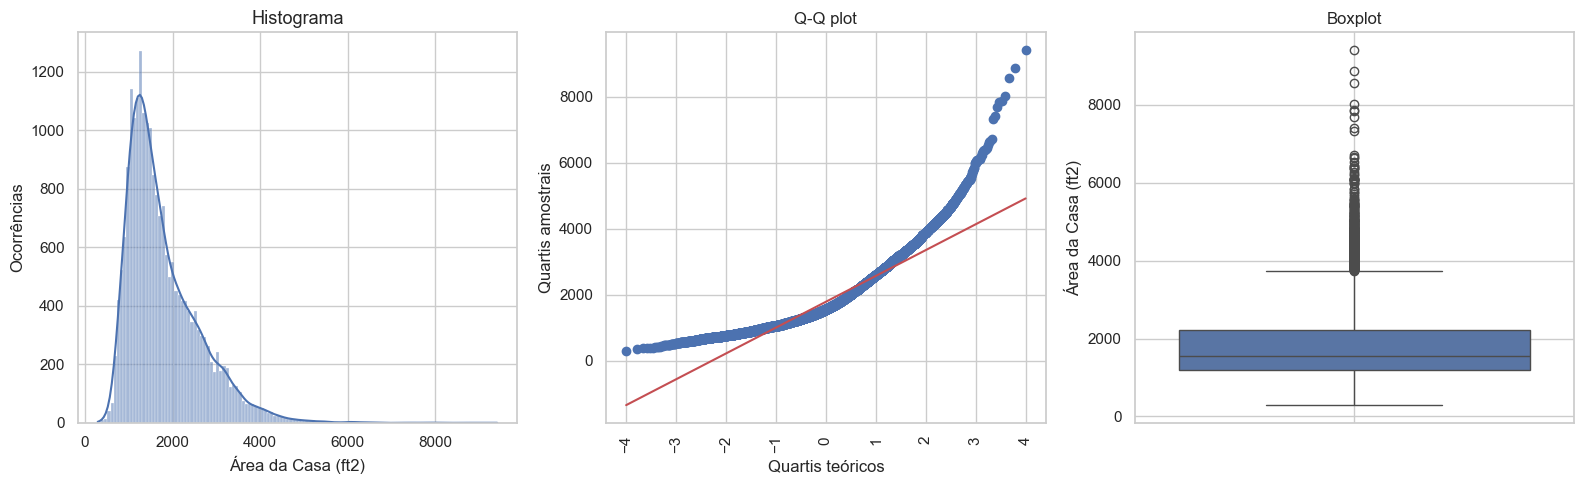

Shapiro-Wilk para a distribuição original:
Estatística=0.894, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


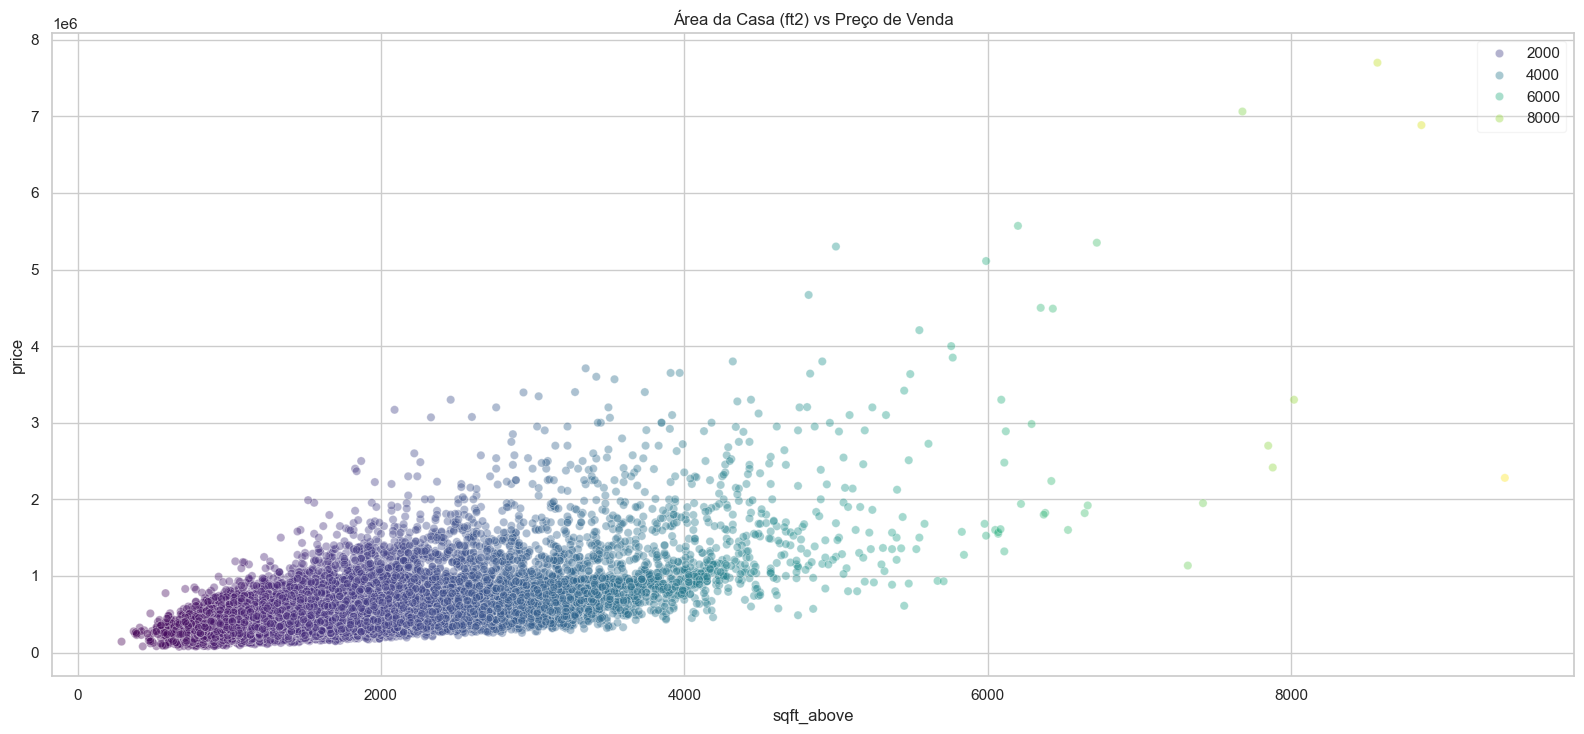

In [18]:
coluna = 'sqft_above'
descricao = 'Área da Casa (ft2)'
hue = None
tipo_variavel = 'Numérica, contínua'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### sqft_basement

Área da casa em pés quadrados abaixo do nível do solo.


**Tipo de Variável**: Numérica, contínua



**Ocorrências por Área Porão (ft2)**


sqft_basement
count   21613.000000
mean      291.509045
std       442.575043
min         0.000000
25%         0.000000
50%         0.000000
75%       560.000000
max      4820.000000

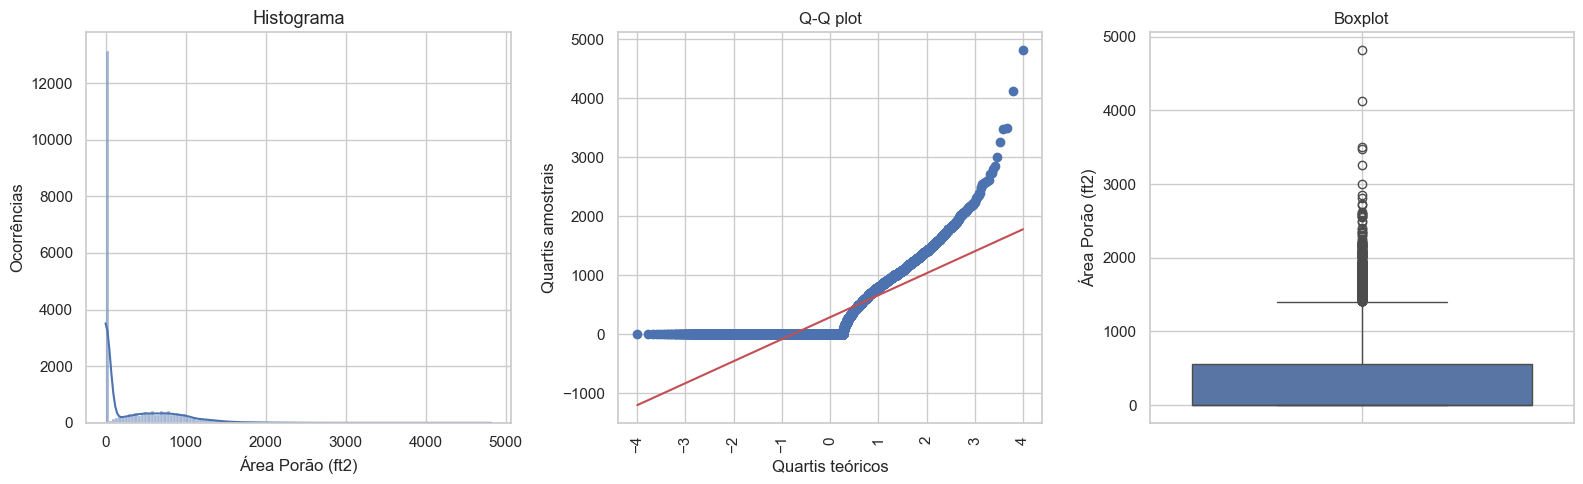

Shapiro-Wilk para a distribuição original:
Estatística=0.710, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


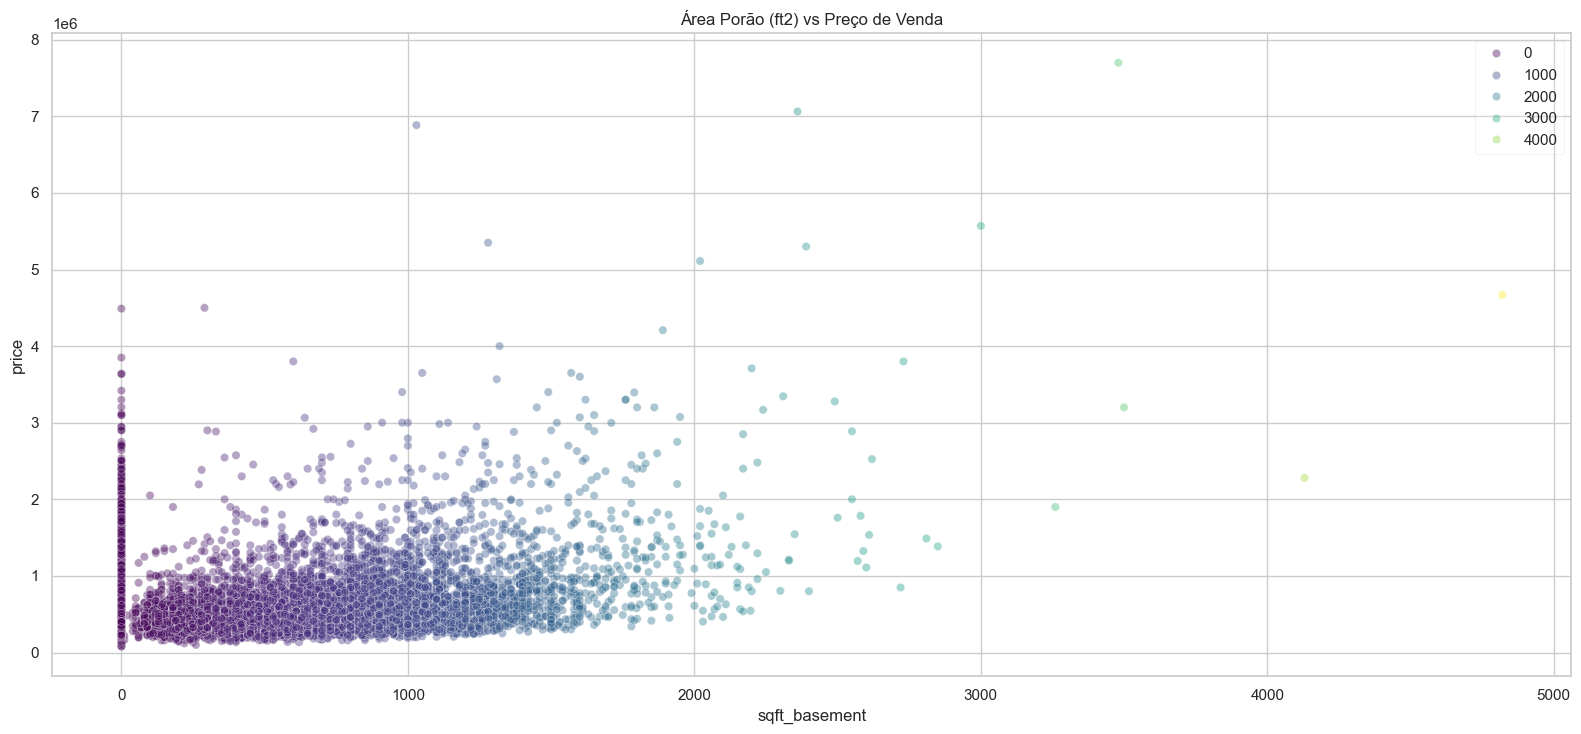

In [19]:
coluna = 'sqft_basement'
descricao = 'Área Porão (ft2)'
hue = None
tipo_variavel = 'Numérica, contínua'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### yr_built
 
Ano em que a casa foi construída.


**Tipo de Variável**: Numérica, discreta



**Ocorrências por Ano de Construção**


yr_built  Ocorrências
0        2014          559
1        2006          454
2        2005          450
3        2004          433
4        2003          422
..        ...          ...
111      1933           30
112      1901           29
113      1902           27
114      1935           24
115      1934           21

[116 rows x 2 columns]

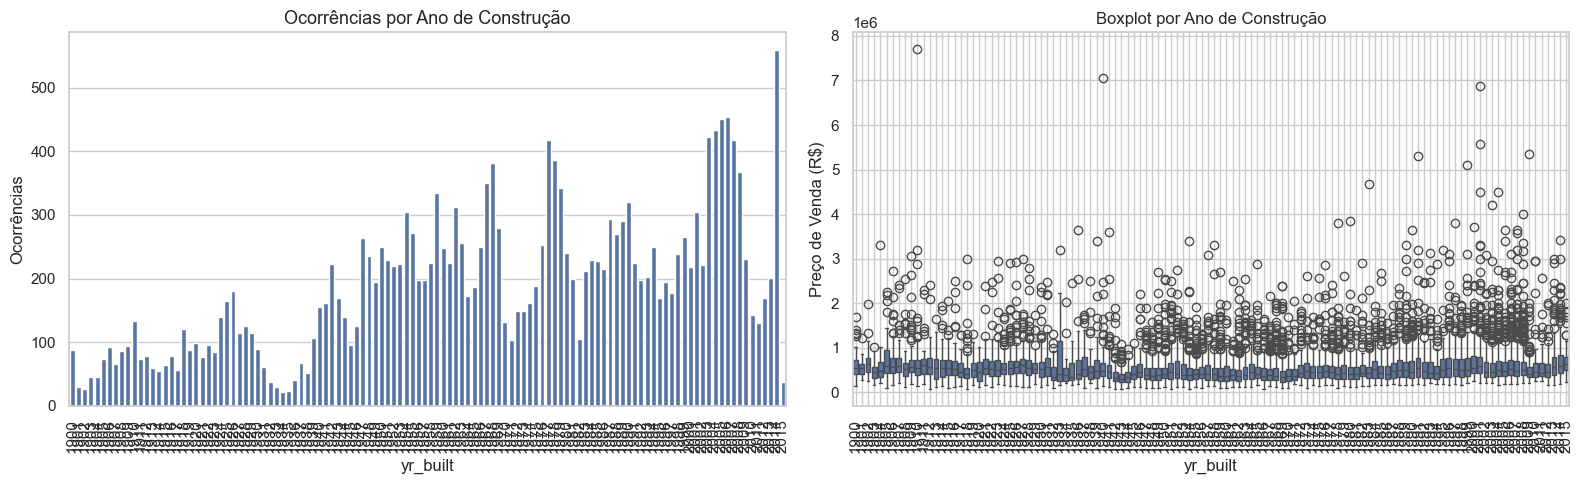

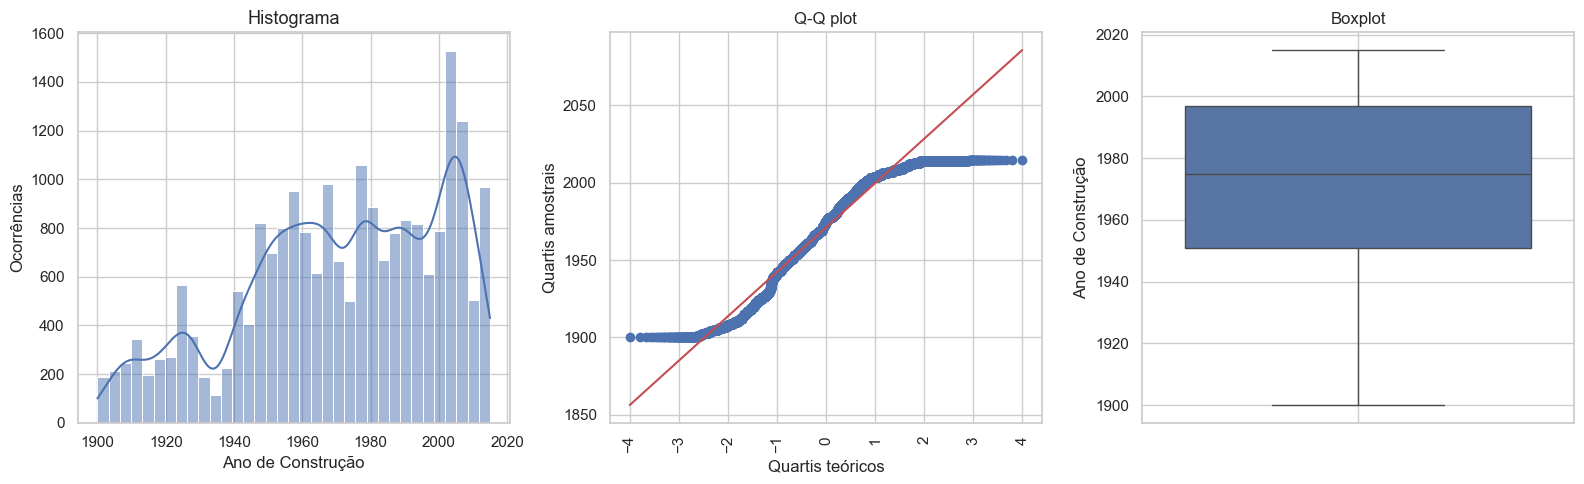

Shapiro-Wilk para a distribuição original:
Estatística=0.954, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


In [20]:
coluna = 'yr_built'
descricao = 'Ano de Construção'
hue = None
tipo_variavel = 'Numérica, discreta'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### yr_renovated

Ano em que a casa foi reformada pela última vez (se aplicável).


**Tipo de Variável**: Numérica, discreta



**Ocorrências por Ano de Reforma**


yr_renovated  Ocorrências
0              0        20699
1           2014           91
2           2013           37
3           2003           36
4           2005           35
..           ...          ...
65          1948            1
66          1951            1
67          1959            1
68          1934            1
69          1944            1

[70 rows x 2 columns]

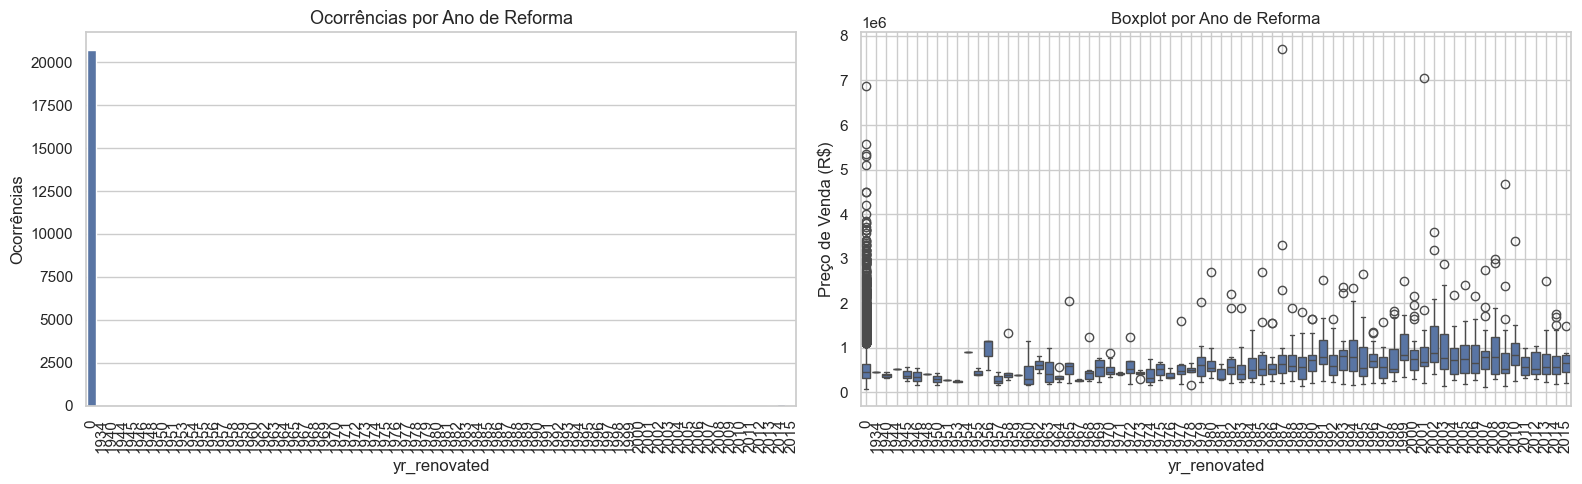

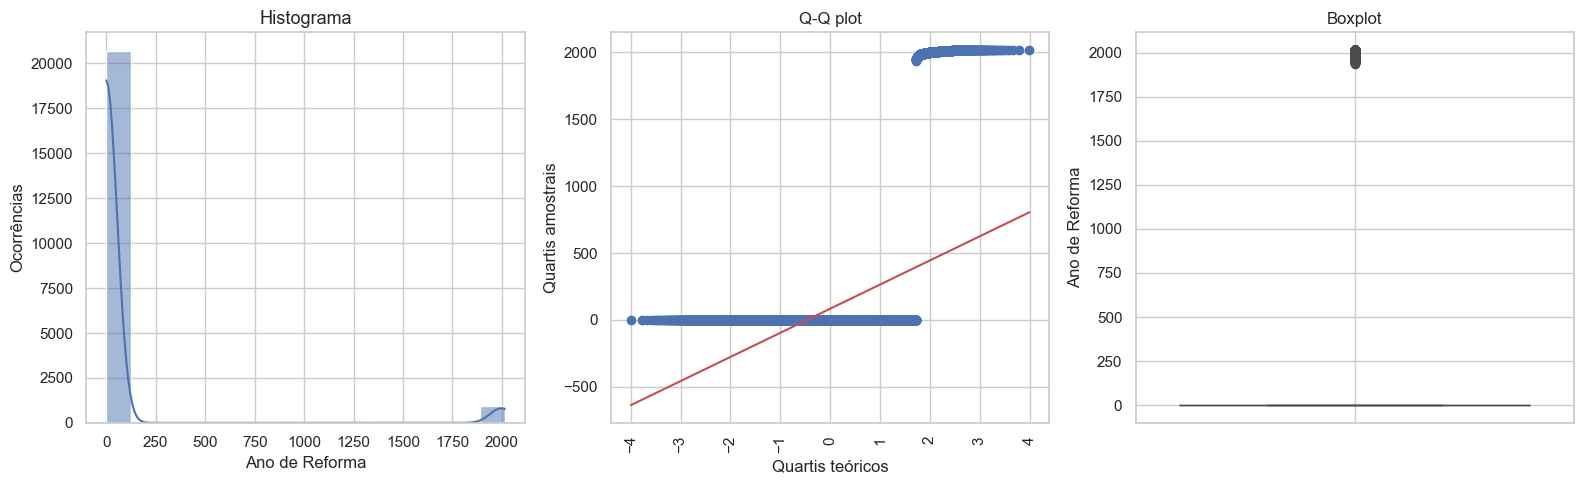

Shapiro-Wilk para a distribuição original:
Estatística=0.201, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


In [21]:
coluna = 'yr_renovated'
descricao = 'Ano de Reforma'
hue = None
tipo_variavel = 'Numérica, discreta'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### zipcode

Código postal da casa.


**Tipo de Variável**: Numérica, discreta



**Ocorrências por Código postal**


zipcode  Ocorrências
0     98103          602
1     98038          590
2     98115          583
3     98052          574
4     98117          553
..      ...          ...
65    98102          105
66    98010          100
67    98024           81
68    98148           57
69    98039           50

[70 rows x 2 columns]

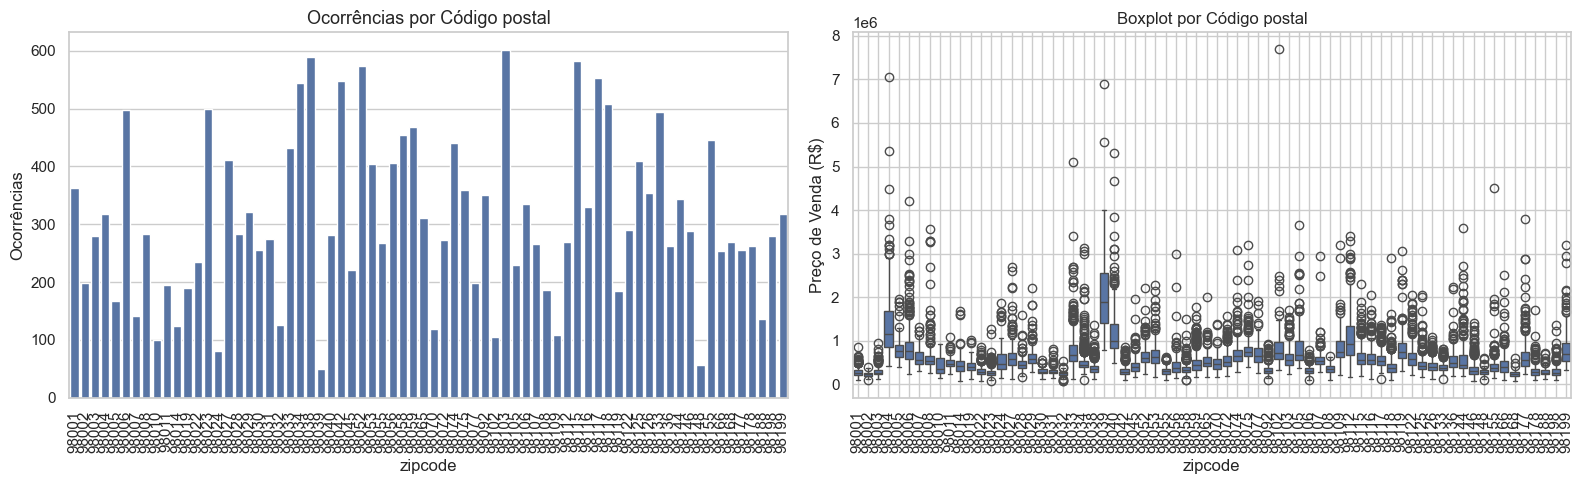

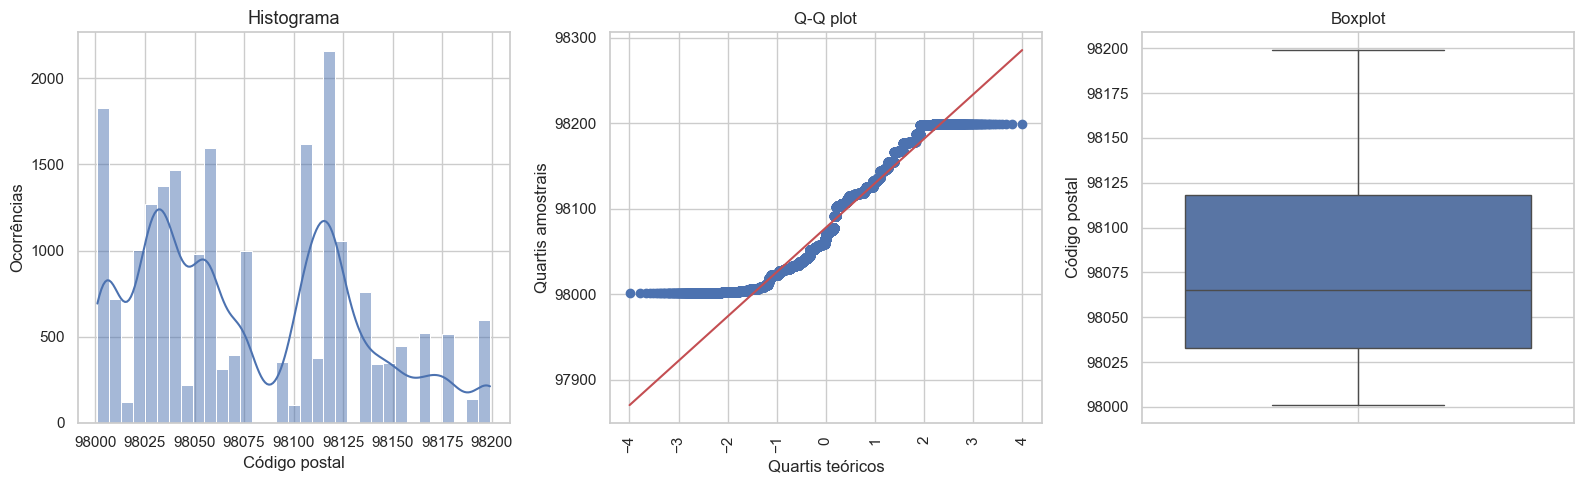

Shapiro-Wilk para a distribuição original:
Estatística=0.943, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


In [22]:
coluna = 'zipcode'
descricao = 'Código postal'
hue = None
tipo_variavel = 'Numérica, discreta'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### lat

Latitude da casa.


**Tipo de Variável**: Numérica, contínua



**Ocorrências por Latitude**


lat
count  21613.000000
mean      47.560053
std        0.138564
min       47.155900
25%       47.471000
50%       47.571800
75%       47.678000
max       47.777600

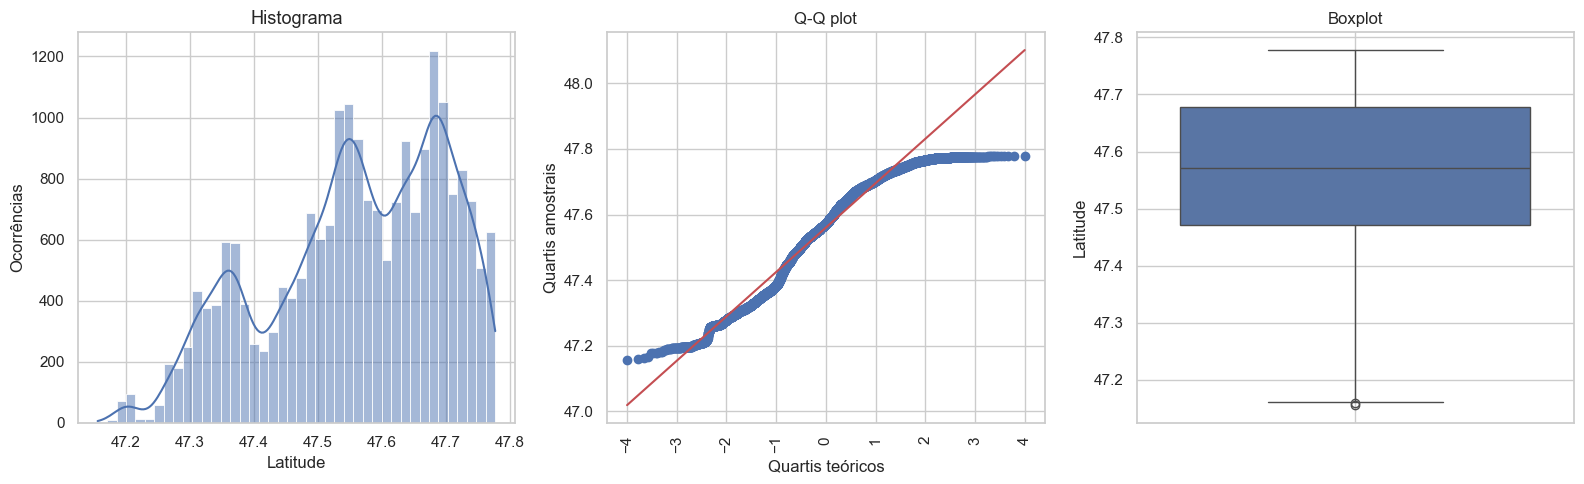

Shapiro-Wilk para a distribuição original:
Estatística=0.957, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


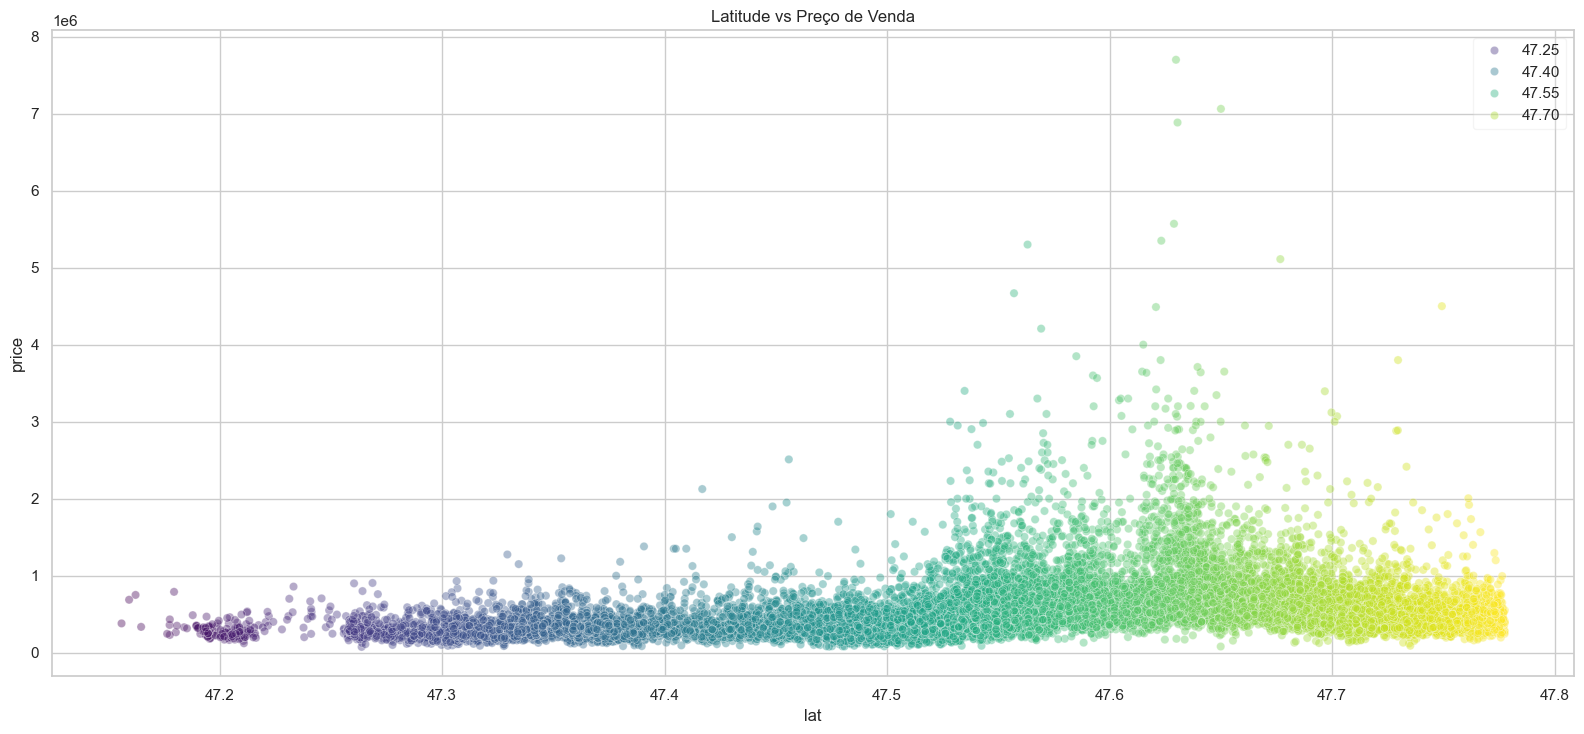

In [23]:
coluna = 'lat'
descricao = 'Latitude'
hue = None
tipo_variavel = 'Numérica, contínua'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### long

Longitude da casa.


**Tipo de Variável**: Numérica, contínua



**Ocorrências por Longitude**


long
count  21613.000000
mean    -122.213896
std        0.140828
min     -122.519000
25%     -122.328000
50%     -122.230000
75%     -122.125000
max     -121.315000

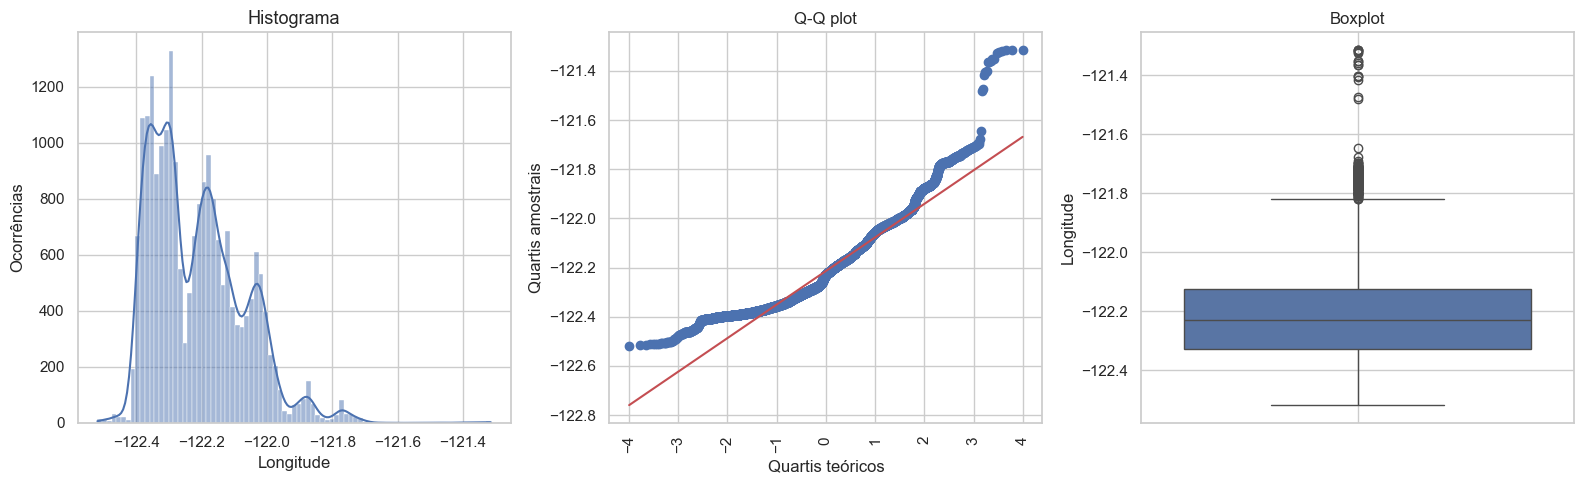

Shapiro-Wilk para a distribuição original:
Estatística=0.940, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


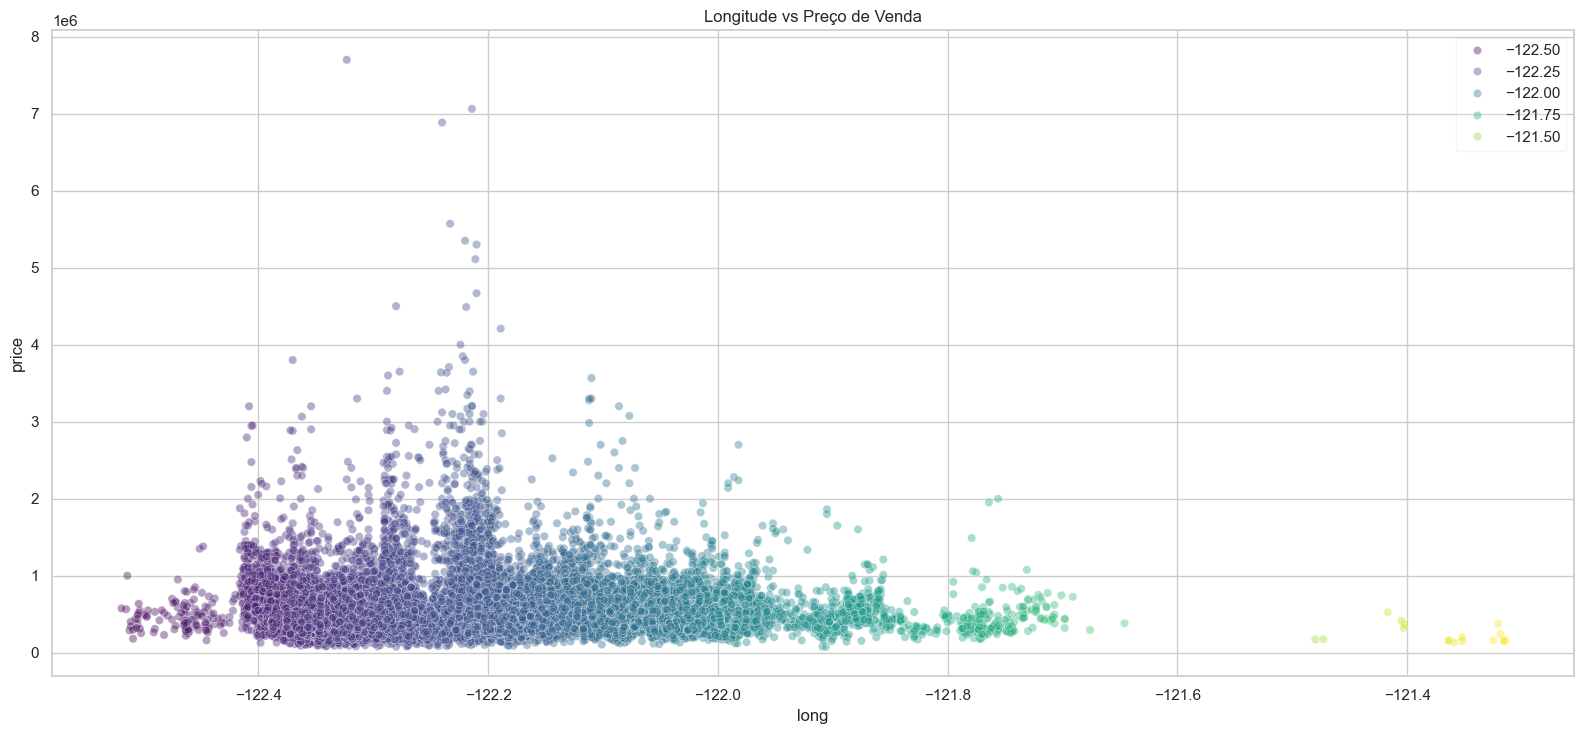

In [24]:
coluna = 'long'
descricao = 'Longitude'
hue = None
tipo_variavel = 'Numérica, contínua'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### sqft_living15

Área útil média dos 15 vizinhos mais próximos em pés quadrados.


**Tipo de Variável**: Numérica, contínua



**Ocorrências por Área útil média dos 15 vizinhos**


sqft_living15
count   21613.000000
mean     1986.552492
std       685.391304
min       399.000000
25%      1490.000000
50%      1840.000000
75%      2360.000000
max      6210.000000

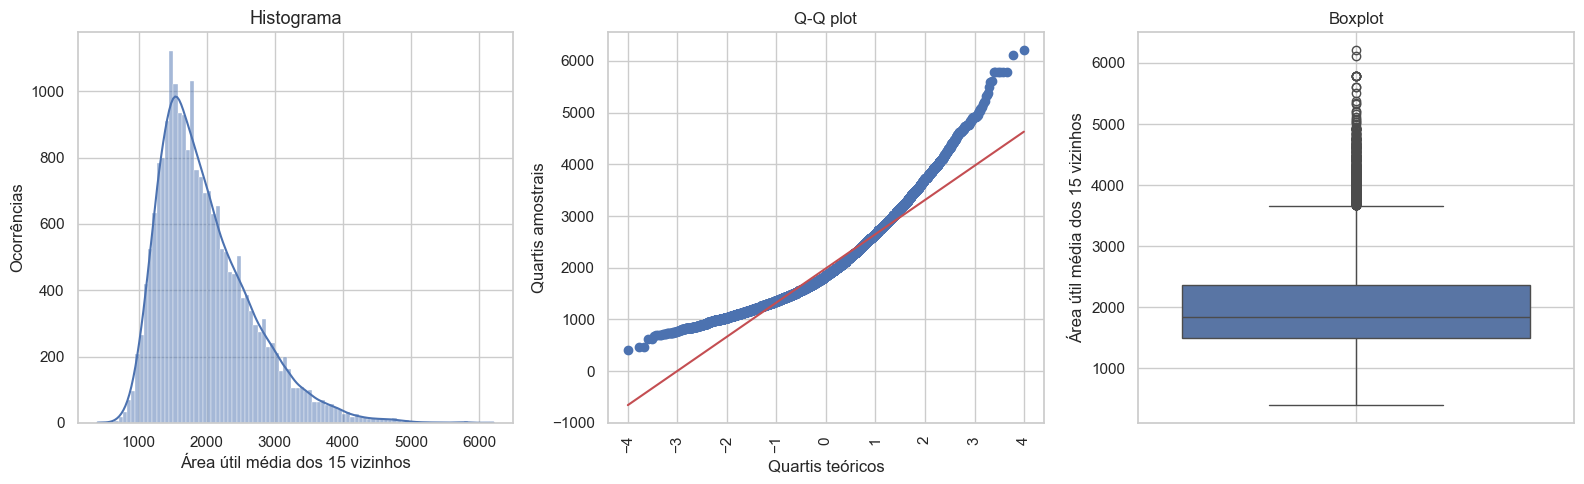

Shapiro-Wilk para a distribuição original:
Estatística=0.932, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


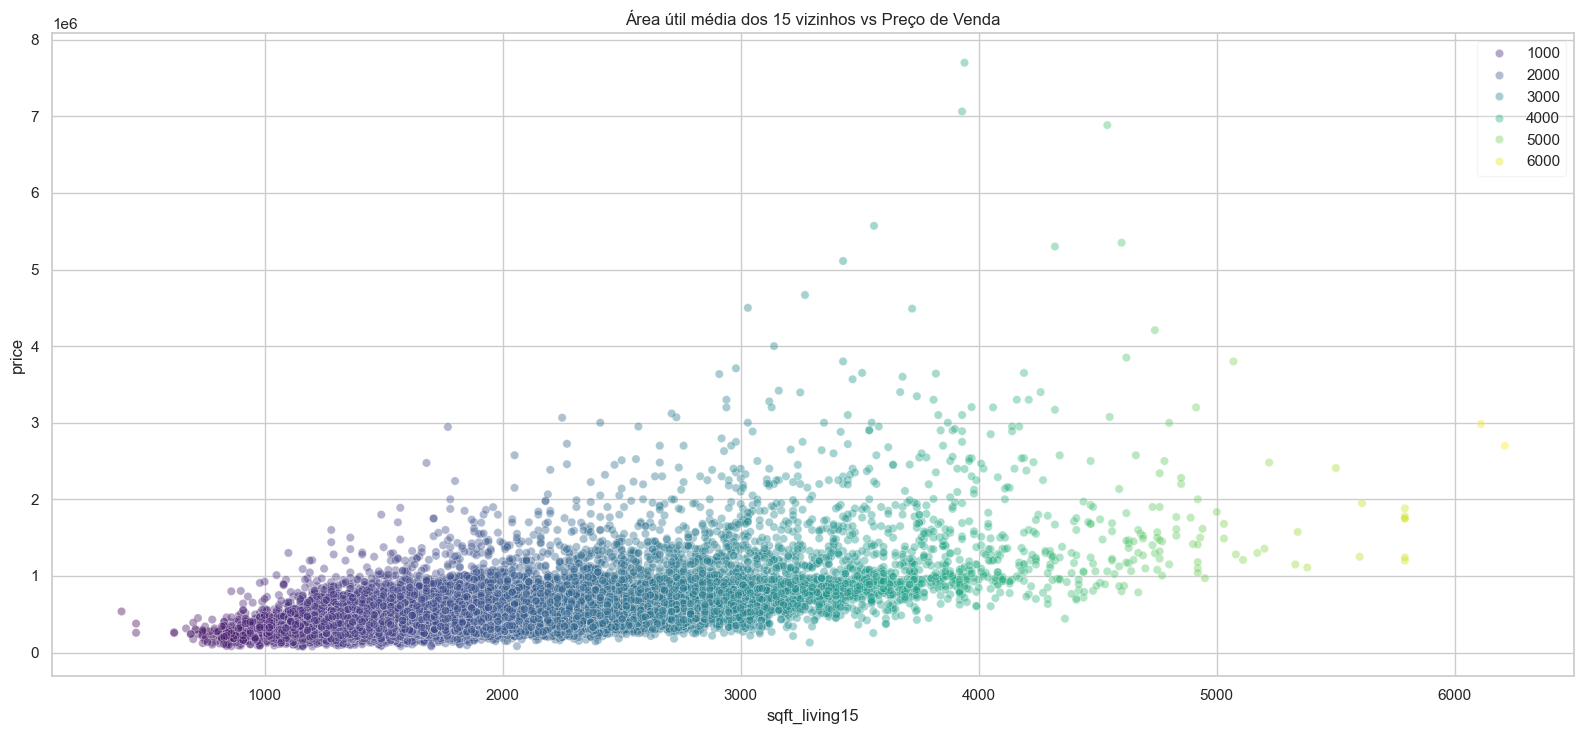

In [25]:
coluna = 'sqft_living15'
descricao = 'Área útil média dos 15 vizinhos'
hue = None
tipo_variavel = 'Numérica, contínua'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### sqft_lot15

Área média do terreno dos 15 vizinhos mais próximos em pés quadrados.


**Tipo de Variável**: Numérica, contínua



**Ocorrências por Área média do terreno dos 15 vizinhos**


sqft_lot15
count   21613.000000
mean    12768.455652
std     27304.179631
min       651.000000
25%      5100.000000
50%      7620.000000
75%     10083.000000
max    871200.000000

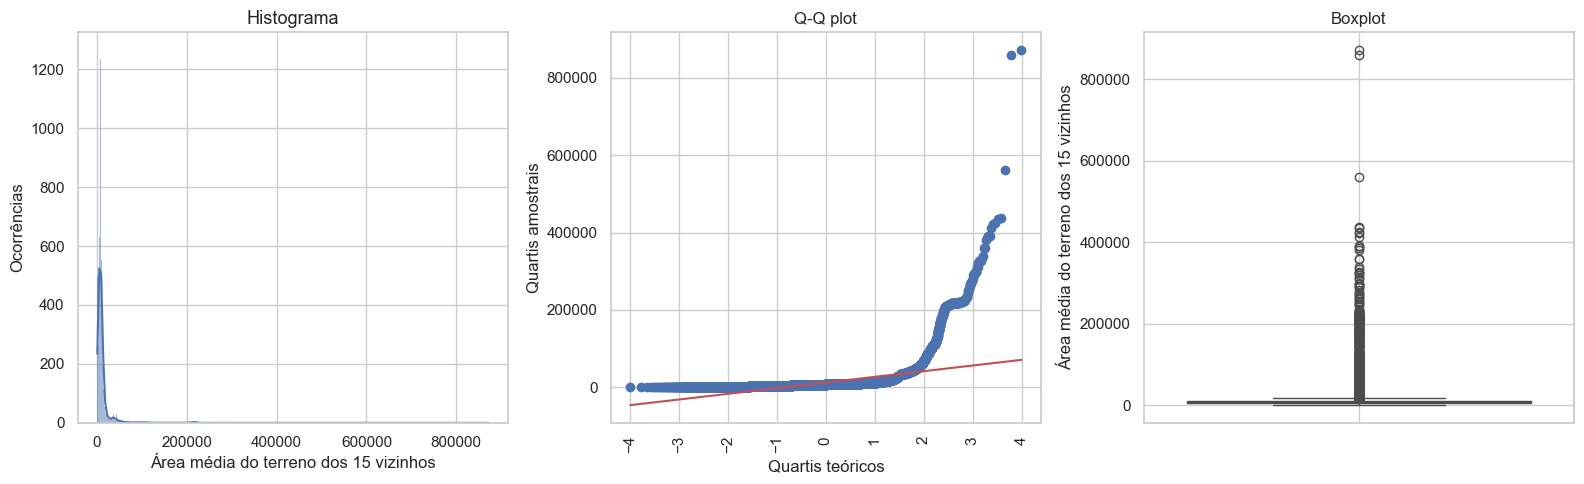

Shapiro-Wilk para a distribuição original:
Estatística=0.287, p=0.000
Amostra não parece ser normalmente distribuída (rejeita H0)


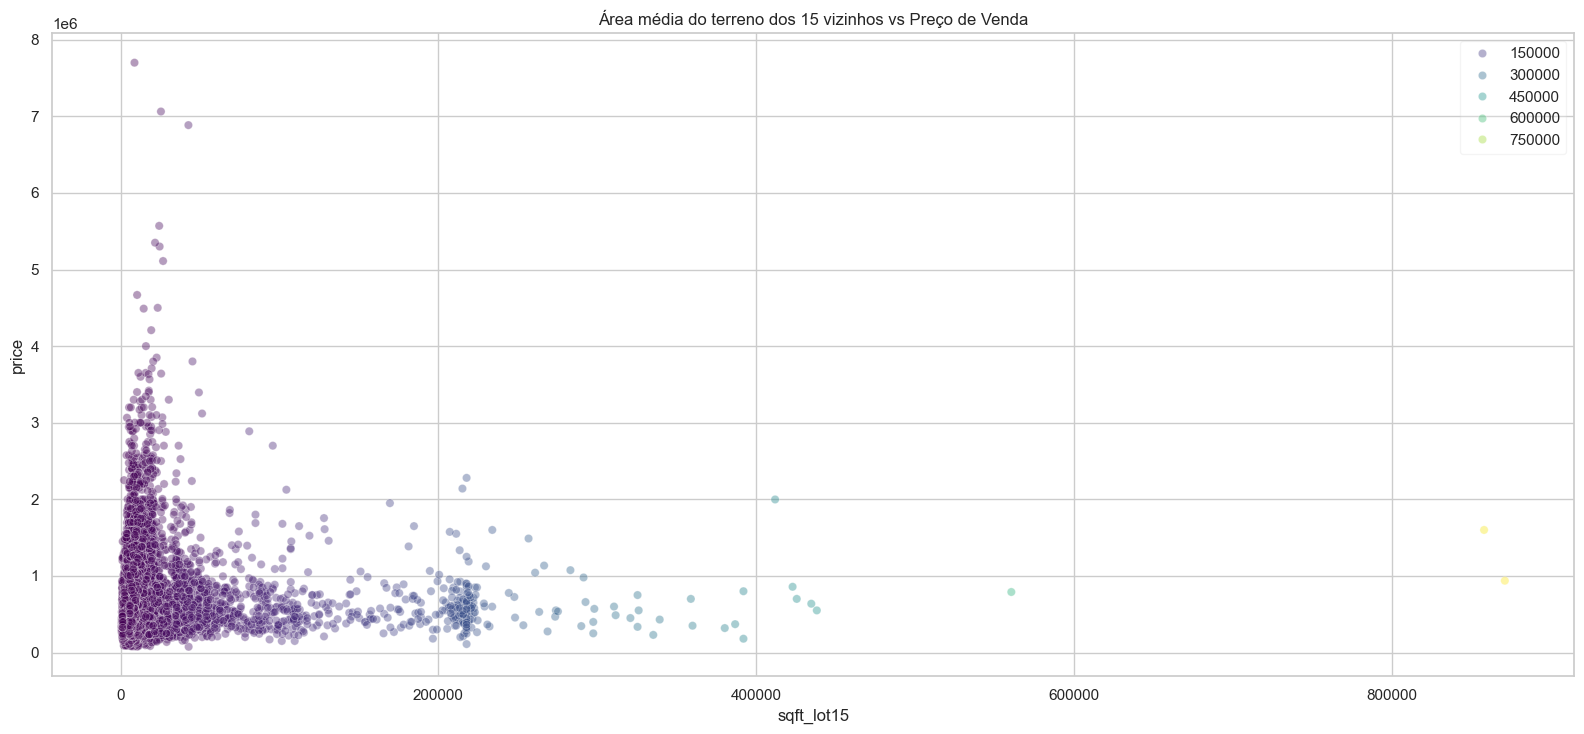

In [26]:
coluna = 'sqft_lot15'
descricao = 'Área média do terreno dos 15 vizinhos'
hue = None
tipo_variavel = 'Numérica, contínua'

display(Markdown(f"""
**Tipo de Variável**: {tipo_variavel}
"""))

display(Markdown(f"""
**Ocorrências por {descricao}**
"""))

if tipo_variavel == 'Numérica, discreta':
    df_counts = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'Ocorrências'})
    display(df_counts)
    plot_histogram_boxplot(df, coluna, descricao, hue)
    plot_hist_qq_box(df, coluna, descricao)
elif tipo_variavel == 'Numérica, contínua':
    display(df[coluna].describe().to_frame())
    plot_hist_qq_box(df, coluna, descricao)
    plot_scatter(df, coluna, descricao)

### Correlação

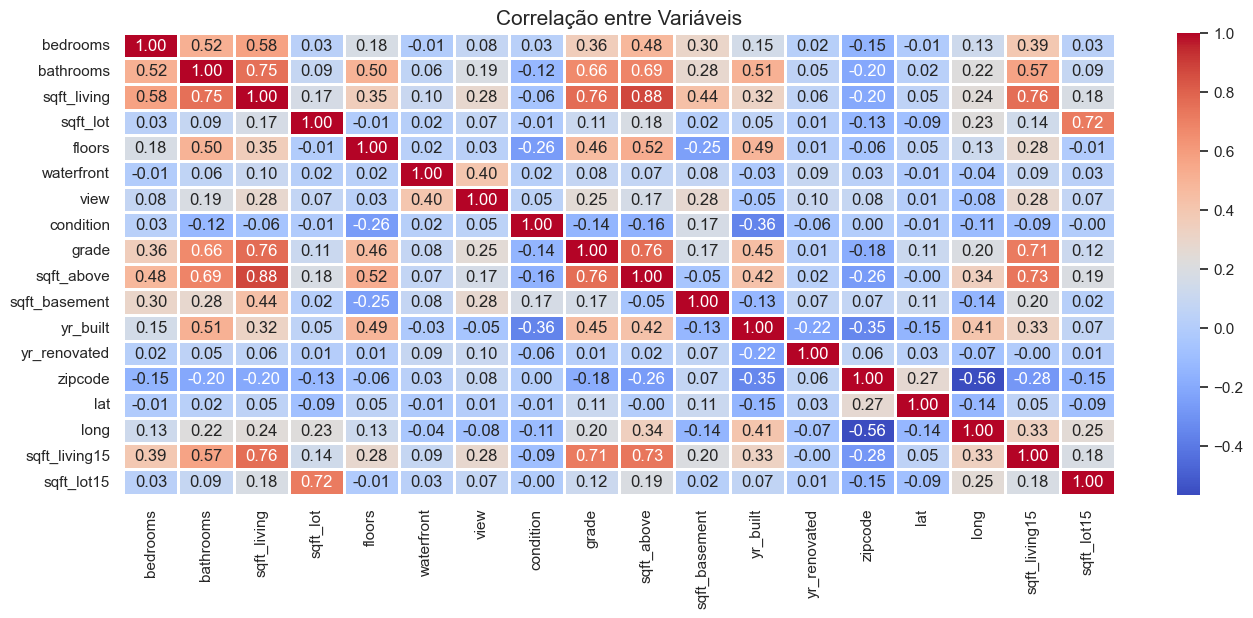

In [27]:
corr = df.drop(columns='price').corr()

plt.figure(figsize=(16, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title('Correlação entre Variáveis', fontsize=15)
plt.show()

### Pairplot

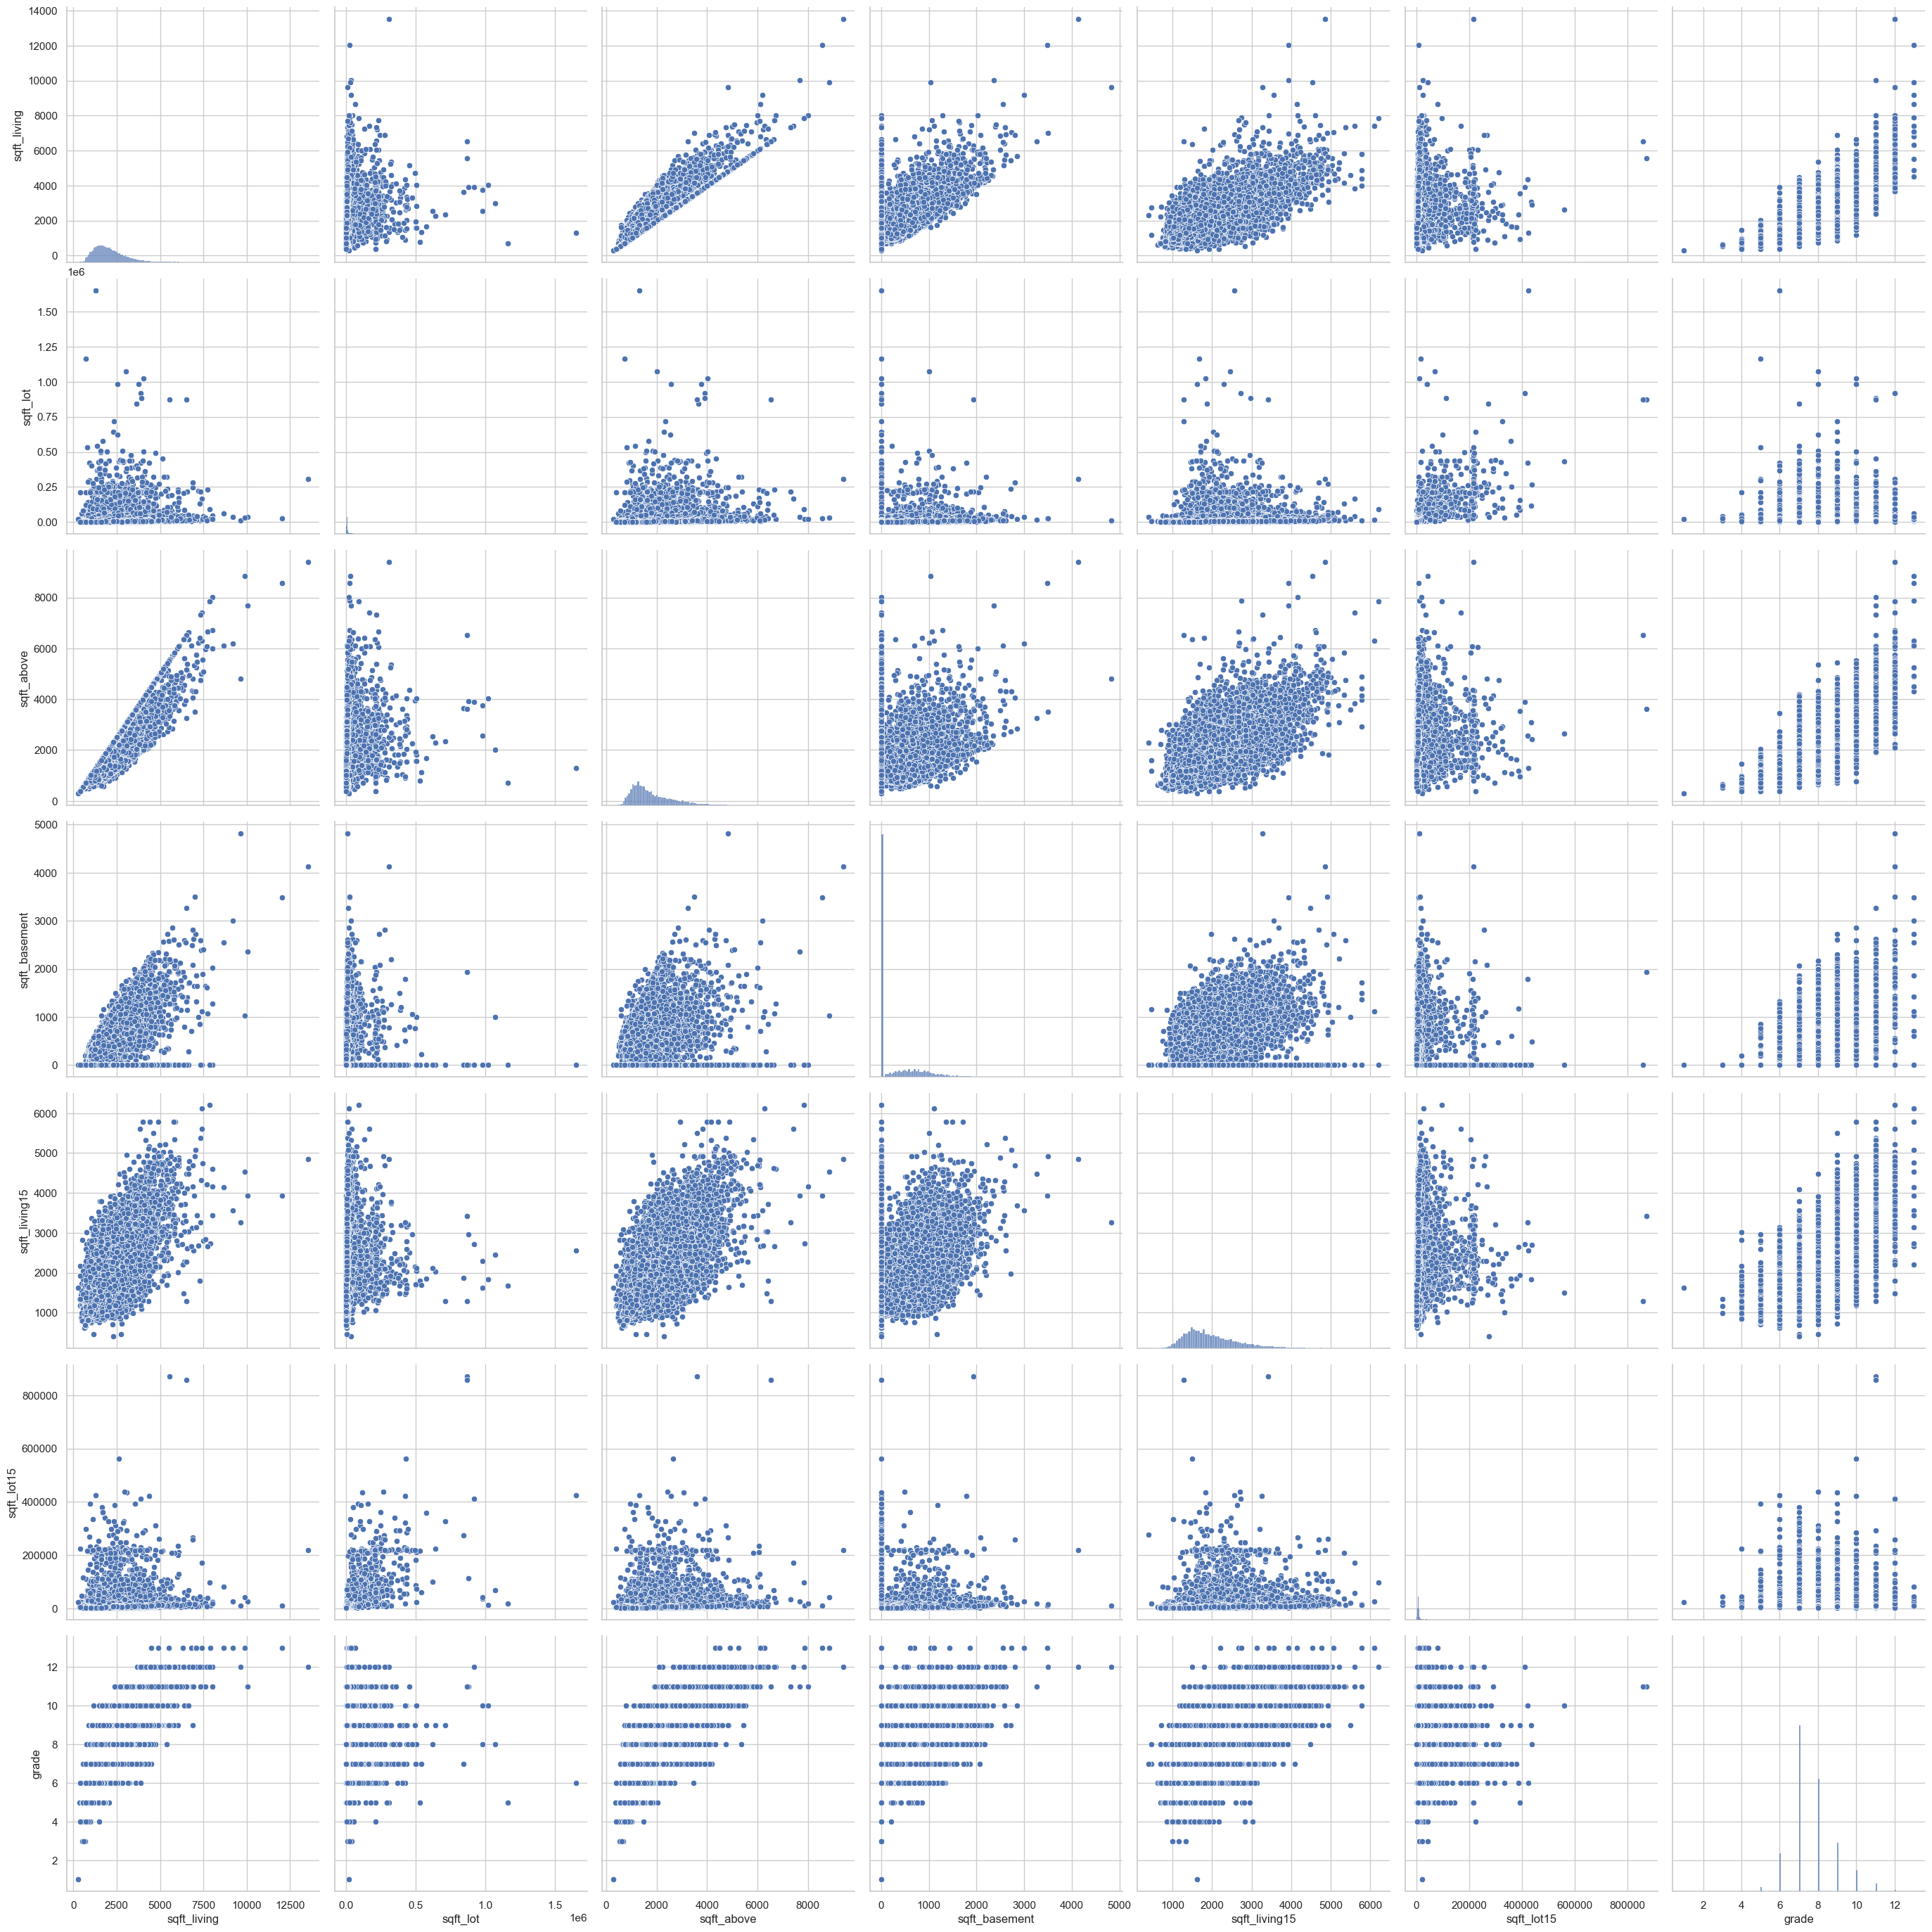

In [28]:
pairplot_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'grade']
sns.pairplot(df[pairplot_cols], height=4)
plt.show()

## Regressão Linear

### Regressão Preliminar

In [29]:
y = df['price']
X = df.drop(columns='price')

X_with_constant = sm.add_constant(X)

lm = sm.OLS(y, X_with_constant, missing='drop').fit()
predictions = lm.predict(X_with_constant)
print(list(predictions)[:5])

[208877.94625903887, 734051.8248941405, 380504.72486626904, 455050.8662114506, 440955.62848609313]


In [30]:
lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Ordinary least squares
==================================================================================
Model:                    OLS                  Adj. R-squared:         0.700      
Dependent Variable:       price                AIC:                    589241.5583
Date:                     2025-01-25 20:02     BIC:                    589385.2172
No. Observations:         21613                Log-Likelihood:         -2.9460e+05
Df Model:                 17                   F-statistic:            2960.      
Df Residuals:             21595                Prob (F-statistic):     0.00       
R-squared:                0.700                Scale:                  4.0501e+10 
----------------------------------------------------------------------------------
                 Coef.       Std.Err.      t     P>|t|     [0.025        0.975]   
----------------------------------------------------------------------------------
const         6690324.6031 2931484.9753   2.2822 0.0225  944397.5807 12436251.6255
bedrooms       -35766.5414    1891.8427 -18.9057 0.0000  -39474.6929   -32058.3900
bathrooms       41144.2785    3253.6777  12.6455 0.0000   34766.8300    47521.7270
sqft_living       110.4401       2.2696  48.6611 0.0000     105.9915      114.8886
sqft_lot            0.1286       0.0479   2.6835 0.0073       0.0347        0.2225
floors           6689.5501    3595.8591   1.8603 0.0628    -358.5993    13737.6995
waterfront     582960.4584   17360.0951  33.5805 0.0000  548933.3900   616987.5268
view            52870.9424    2140.0546  24.7054 0.0000   48676.2774    57065.6073
condition       26385.6491    2351.4612  11.2210 0.0000   21776.6116    30994.6867
grade           95890.4452    2152.7892  44.5424 0.0000   91670.8194   100110.0709
sqft_above         70.7880       2.2533  31.4152 0.0000      66.3714       75.2047
sqft_basement      39.6604       2.6466  14.9853 0.0000      34.4729       44.8480
yr_built        -2620.2232      72.6591 -36.0619 0.0000   -2762.6405    -2477.8059
yr_renovated       19.8126       3.6556   5.4198 0.0000      12.6474       26.9778
zipcode          -582.4199      32.9858 -17.6567 0.0000    -647.0745     -517.7652
lat            602748.2264   10734.7234  56.1494 0.0000  581707.3759   623789.0770
long          -214729.8283   13133.9015 -16.3493 0.0000 -240473.2450  -188986.4115
sqft_living15      21.6814       3.4477   6.2886 0.0000      14.9236       28.4392
sqft_lot15         -0.3826       0.0733  -5.2224 0.0000      -0.5263       -0.2390
----------------------------------------------------------------------------------
Omnibus:              18384.201        Durbin-Watson:           1.990             
Prob(Omnibus):        0.000            Jarque-Bera (JB):        1868224.491       
Skew:                 3.566            Prob(JB):                0.000             
Kurtosis:             47.985           Condition No.:           334700110946062784
==================================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly
specified.
[2] The smallest eigenvalue is 1.95e-21. This might indicate that
there are strong multicollinearity problems or that the design
matrix is singular.
"""

Os coeficientes poderiam ser interpretados da seguinte forma:

* **const:**  6690324.603. Este é o valor previsto para o preço de um imóvel quando todas as outras variáveis no modelo são iguais a zero.  É importante notar que, neste caso, o valor não tem interpretação prática, pois não existe um imóvel com zero quartos, zero banheiros, zero área construída, etc. Serve apenas como um ponto de partida para o modelo.

* **bedrooms:** -35766.541.  Mantendo todas as outras variáveis constantes, um aumento de um quarto está associado a uma diminuição de $35.766,54 no preço do imóvel.  Essa relação negativa pode parecer contraintuitiva, mas pode ser explicada por outros fatores. Por exemplo, casas com mais quartos podem estar localizadas em áreas menos valorizadas ou ter uma qualidade de construção inferior.

* **bathrooms:** 41144.278.  Mantendo todas as outras variáveis constantes, um aumento de um banheiro está associado a um aumento de $41.144,28 no preço do imóvel.  

* **sqft_living:** 110.440. Mantendo todas as outras variáveis constantes, um aumento de um pé quadrado na área construída está associado a um aumento de $110,44 no preço do imóvel.

* **sqft_lot:** 0.128. Mantendo todas as outras variáveis constantes, um aumento de um pé quadrado na área do lote está associado a um aumento de $0,13 no preço do imóvel.

* **floors:** 6689.550. Mantendo todas as outras variáveis constantes, um aumento de um andar está associado a um aumento de $6.689,55 no preço do imóvel.

* **waterfront:** 582960.458. Imóveis com vista para o mar (waterfront = 1) tendem a ter um preço $582.960,46 maior do que imóveis sem vista para a água (waterfront = 0), mantendo todas as outras variáveis constantes.

* **view:** 52870.942.  O aumento de uma unidade na variável vista tende a ter um preço $52.870,94 maior, mantendo todas as outras variáveis constantes.

* **condition:** 26385.649. Mantendo todas as outras variáveis constantes, um aumento de um ponto na condição do imóvel está associado a um aumento de $26.385,65 no preço.

* **grade:** 95890.445. Mantendo todas as outras variáveis constantes, um aumento de um ponto na qualidade de construção do imóvel está associado a um aumento de $95.890,45 no preço.

* **sqft_above:** 70.788. Mantendo todas as outras variáveis constantes, um aumento de um pé quadrado na área construída acima do solo está associado a um aumento de $70,79 no preço do imóvel.

* **sqft_basement:** 39.660. Mantendo todas as outras variáveis constantes, um aumento de um pé quadrado na área do porão está associado a um aumento de $39,66 no preço do imóvel.

* **yr_built:** -2620.223. Mantendo todas as outras variáveis constantes, um aumento de um ano na idade do imóvel está associado a uma diminuição de $2.620,22 no preço.

* **yr_renovated:** 19.812. Mantendo todas as outras variáveis constantes, um aumento de um ano na data da última reforma está associado a um aumento de $19,81 no preço do imóvel.

* **zipcode:** -582.419. Mantendo todas as outras variáveis constantes, um aumento de uma unidade no código postal está associado a uma diminuição de $582,42 no preço do imóvel.

* **lat:** 602748.226. Mantendo todas as outras variáveis constantes, um aumento de uma unidade na latitude está associado a um aumento de $602.748,23 no preço do imóvel.

* **long:** -214729.828. Mantendo todas as outras variáveis constantes, um aumento de uma unidade na longitude está associado a uma diminuição de $214.729,83 no preço do imóvel.

* **sqft_living15:** 21.681. Mantendo todas as outras variáveis constantes, um aumento de um pé quadrado na área construída dos 15 vizinhos mais próximos está associado a um aumento de $21,68 no preço do imóvel.

* **sqft_lot15:** -0.382. Mantendo todas as outras variáveis constantes, um aumento de um pé quadrado na área do lote dos 15 vizinhos mais próximos está associado a uma diminuição de $0,38 no preço do imóvel.

Entretanto, para uma análise mais precisa, é necessário avaliar a significância estatística das variáveis e a qualidade do ajuste do modelo. Para isso, vamos realizar uma análise mais detalhada e validar os pressupostos para a regressão.

### Validação dos Pressupostos e Diagnóstico do Modelo

In [31]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]
vif["features"] = X_with_constant.columns
vif

VIF Factor       features
0   4.585941e+06          const
1   1.652063e+00       bedrooms
2   3.350793e+00      bathrooms
3            inf    sqft_living
4   2.102522e+00       sqft_lot
5   2.011907e+00         floors
6   1.203766e+00     waterfront
7   1.435160e+00           view
8   1.249475e+00      condition
9   3.417046e+00          grade
10           inf     sqft_above
11           inf  sqft_basement
12  2.430649e+00       yr_built
13  1.150554e+00   yr_renovated
14  1.662174e+00        zipcode
15  1.180630e+00            lat
16  1.825579e+00           long
17  2.979713e+00  sqft_living15
18  2.135668e+00     sqft_lot15

Há a presença de multicolinearidade entre variáveis e talvez seja necessário remover algumas variáveis do modelo ou realizar transformações.

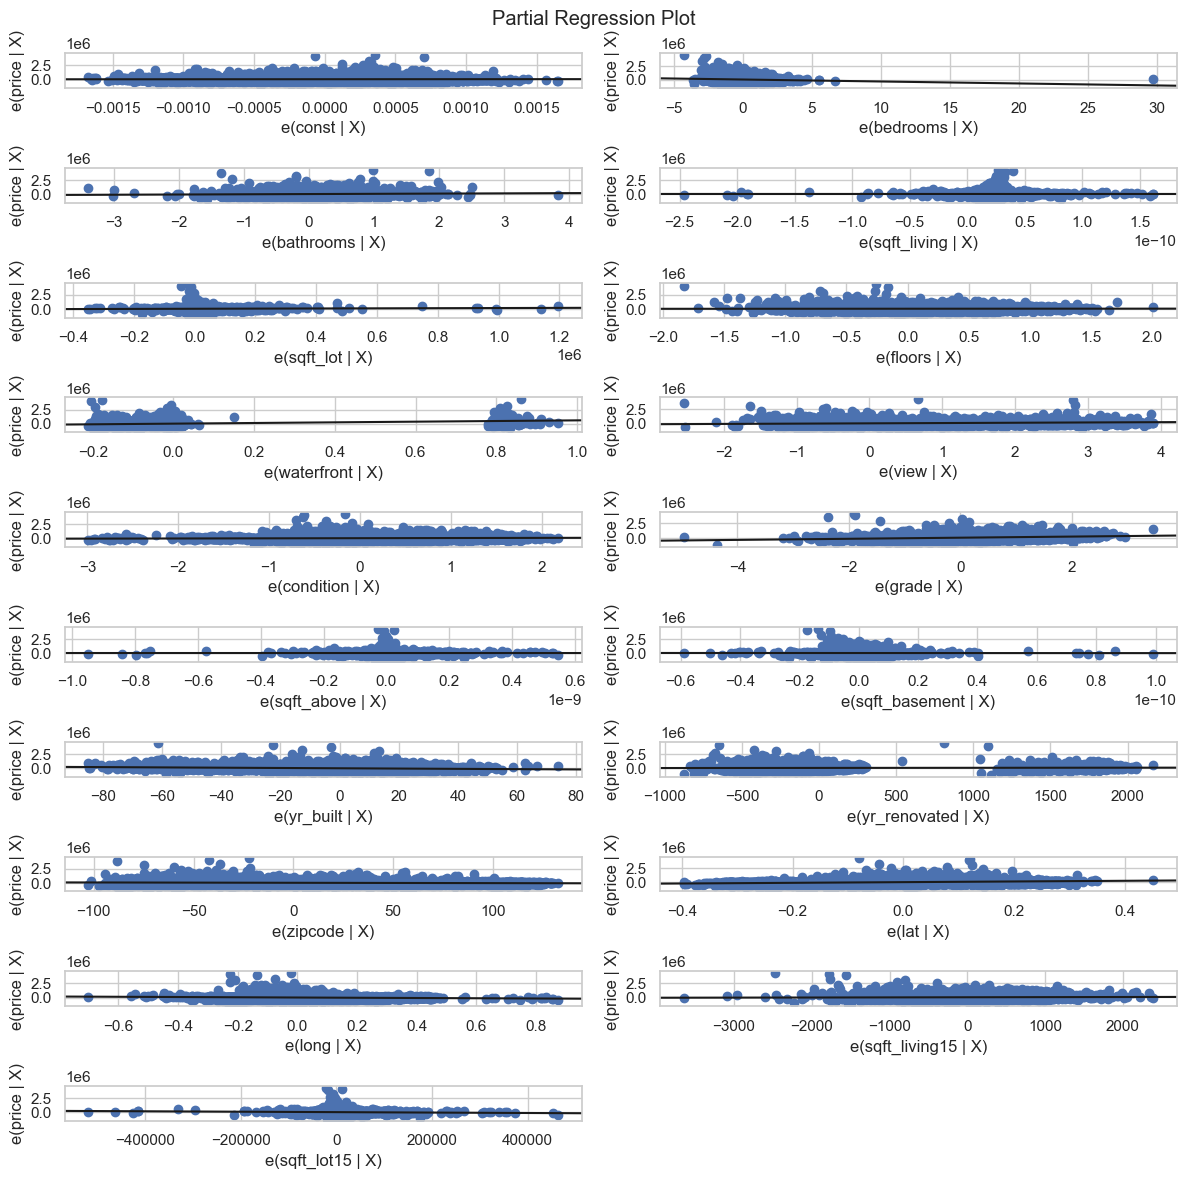

In [32]:
fig = sm.graphics.plot_partregress_grid(lm)
fig.set_size_inches(12,12)
fig.tight_layout(pad=1.0)
plt.show()

In [33]:
name = ['Multiplicador de Lagrange - Teste Breusch e Pagan de Heterocedasticidade ', 
        'p-value', 'f-value', 'f: p-value']
test = sm.stats.het_breuschpagan(lm.resid, lm.model.exog)
lzip(name, test)

[('Multiplicador de Lagrange - Teste Breusch e Pagan de Heterocedasticidade ',
  np.float64(2855.618281022421)),
 ('p-value', np.float64(0.0)),
 ('f-value', np.float64(193.38920319343538)),
 ('f: p-value', np.float64(0.0))]

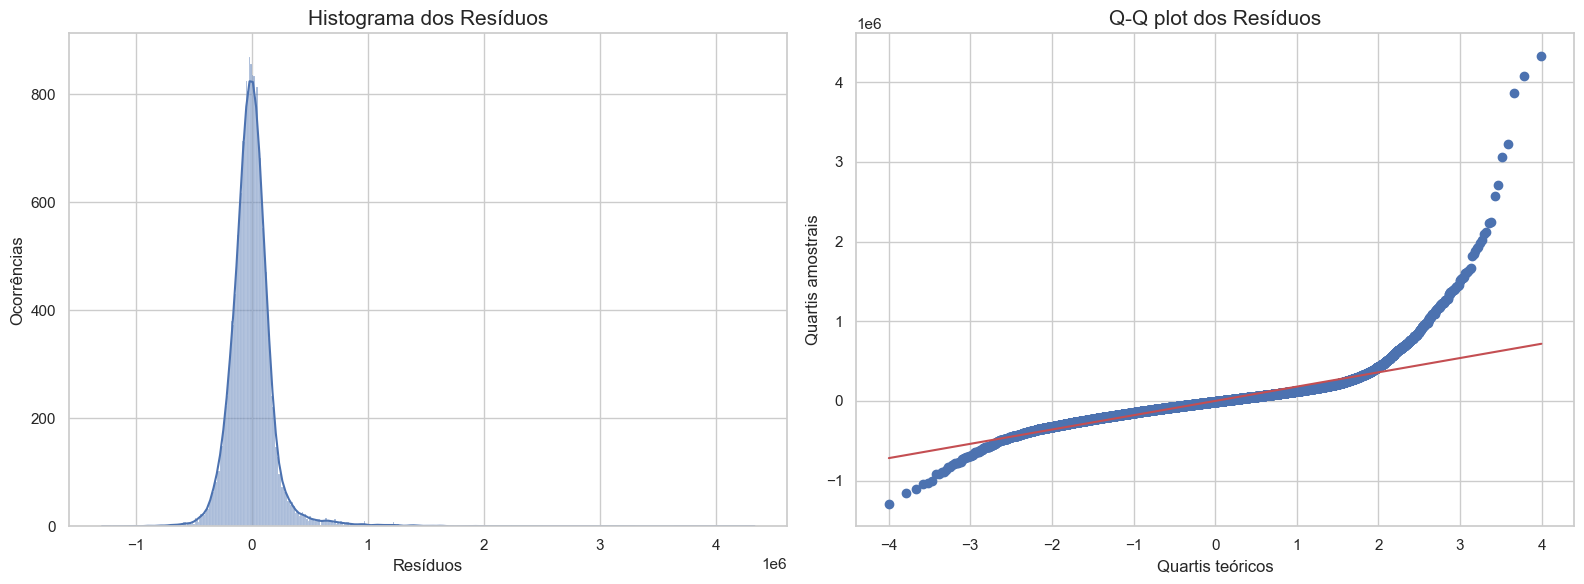

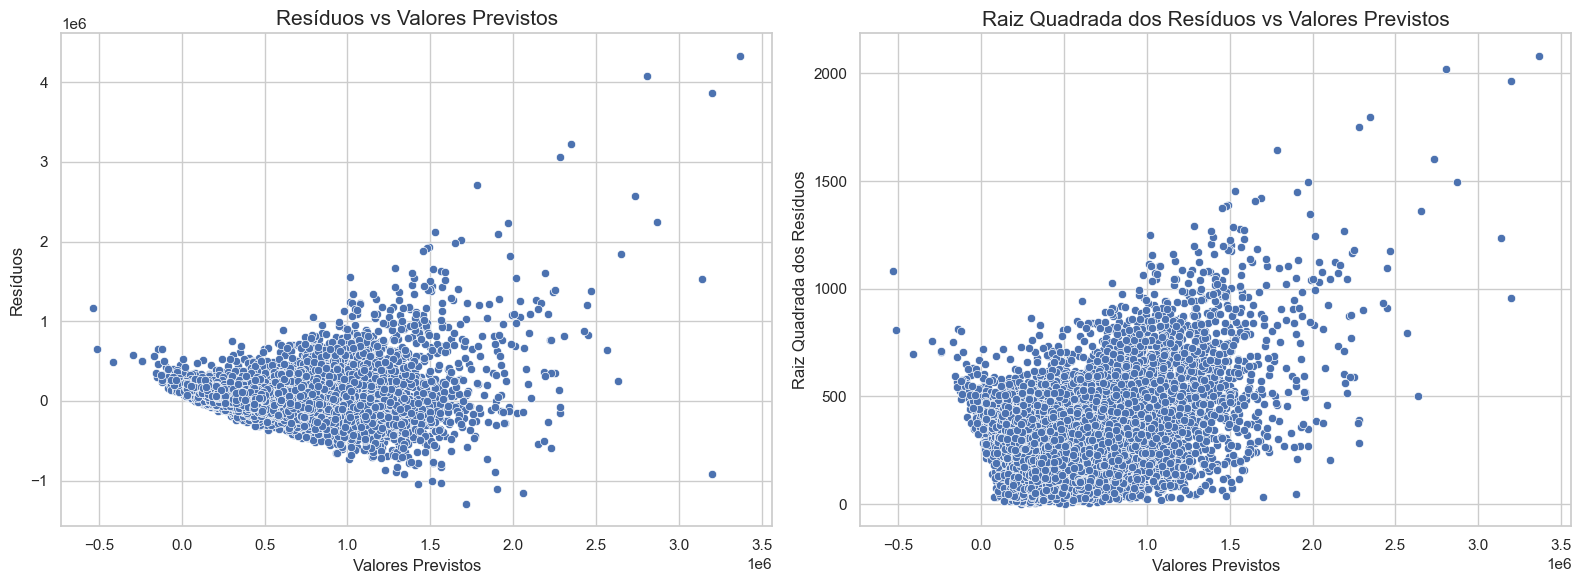

Teste de Shapiro-Wilk para a normalidade dos resíduos:
p-valor: 0.0000. Rejeitamos a hipótese nula de normalidade dos resíduos.


In [34]:
jarque_bera = sm.stats.jarque_bera(lm.resid)
jarque_bera

shapiro(lm.resid)

normaltest(lm.resid)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(lm.resid, kde=True, ax=ax[0])
ax[0].set_title('Histograma dos Resíduos', fontsize=15)
ax[0].set_xlabel('Resíduos')
ax[0].set_ylabel('Ocorrências')

stats.probplot(lm.resid, dist="norm", plot=ax[1])
ax[1].set_title('Q-Q plot dos Resíduos', fontsize=15)
ax[1].set_xlabel('Quartis teóricos')
ax[1].set_ylabel('Quartis amostrais')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x=predictions, y=lm.resid, ax=ax[0])
ax[0].set_title('Resíduos vs Valores Previstos', fontsize=15)
ax[0].set_xlabel('Valores Previstos')
ax[0].set_ylabel('Resíduos')

sns.scatterplot(x=predictions, y=np.sqrt(np.abs(lm.resid)), ax=ax[1])
ax[1].set_title('Raiz Quadrada dos Resíduos vs Valores Previstos', fontsize=15)
ax[1].set_xlabel('Valores Previstos')
ax[1].set_ylabel('Raiz Quadrada dos Resíduos')

plt.tight_layout()
plt.show()

# teste normalidade dos resíduos
print('Teste de Shapiro-Wilk para a normalidade dos resíduos:')
teste_shapiro = shapiro(lm.resid)

if teste_shapiro[1] > 0.05:
    print(f'p-valor: {teste_shapiro[1]:.4f}. Não rejeitamos a hipótese nula de normalidade dos resíduos.')
else:
    print(f'p-valor: {teste_shapiro[1]:.4f}. Rejeitamos a hipótese nula de normalidade dos resíduos.')



Com base nas análises realizadas até o momento, podemos concluir que a utilização de uma regressão robusta dentre outras técnicas é o caminho mais adequado para a construção de um modelo preditivo mais preciso e confiável para o preço de venda dos imóveis. Diversos fatores contribuem para essa decisão, incluindo:


**Presença de outliers**:

O Influence Plot revelou a presença de outliers com alto leverage e alto resíduo studentizado, o que indica que alguns pontos exercem influência desproporcional no ajuste do modelo de regressão linear tradicional, podendo distorcer as estimativas dos coeficientes e comprometer a precisão das previsões.

**Heterocedasticidade**:

O teste de Breusch-Pagan confirmou a presença de heterocedasticidade nos dados, indicando que a variância dos erros não é constante.
Essa violação da suposição de homocedasticidade pode levar a estimativas ineficientes e inferências inválidas no modelo de regressão linear tradicional.

**Multicolinearidade**:

A análise da correlação entre as variáveis independentes e o VIF Factor indicam a presença de multicolinearidade, o que sugere que algumas variáveis estão altamente correlacionadas entre si. Além disso, Cond. No. alto indica possível problemas de multicolinearidade.

**Normalidade dos Resíduos**:

Omnibus e Jarque-Bera com p-valores de 0.00 indicam que os resíduos do modelo não seguem uma distribuição normal. Isso pode ser um problema para a validade de algumas inferências estatísticas. Além disso, o Q-Q Plot mostra que os resíduos não seguem a linha da normal e o teste de Shapiro-Wilk rejeita a hipótese nula de normalidade.

**Linearidade**:

Algumas variáveis independentes aparentemente não apresentam uma relação linear clara com a variável dependente, o que pode comprometer a validade do modelo de regressão linear tradicional. Talvez transformações possa ajudar a melhorar a linearidade.


**Transformações**:

Além de transformações para melhorar a linearidade, também é possível considerar a transformação de algumas variáveis categóricas em variáveis dummy para melhorar o ajuste do modelo. Ainda, transformações como logaritmo ou raiz quadrada podem ser úteis para lidar com a heterocedasticidade e a distribuição dos resíduos.


### Regressão Final

In [35]:
df['years'] =  date.today().year - df['yr_built']
df['years_renovated'] = date.today().year - df['yr_renovated']

continuas = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
categoricas = ['zipcode']
discretas = df.columns.difference(continuas + ['price'] + categoricas)

y = np.log10(df['price'])

X_continuas = np.log10(df[continuas].replace(0, 0.00001))

X_discretas = df[discretas]
X_categoricas = df[categoricas]


# X_categoricas['zipcode'] = pd.cut(X_categoricas['zipcode'], bins=4, labels=False)

X = pd.concat([X_continuas, X_discretas, X_categoricas], axis=1).astype(float)

dropar = ['yr_renovated', 'yr_built']
X = X.drop(columns=dropar)
X = pd.get_dummies(X, drop_first=True, columns=categoricas).astype(float)

# utilizar apenas colunas slecionadas pelo Lasso
lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X, y)
lasso_coef = lasso_model.coef_
print("Lasso Columns:\n")
df_lasso = pd.DataFrame(data=lasso_coef, index=X.columns, columns=['Coefficient'])
lasso_selected = list(df_lasso[df_lasso['Coefficient']>0].index)
print(lasso_selected)

X = X[lasso_selected]
X_with_constant = sm.add_constant(X)

lm_robusto = sm.OLS(y, X_with_constant, missing='drop').fit(cov_type='HC0')
predictions = lm_robusto.predict(X_with_constant)

lm_robusto.summary2()

Lasso Columns:

['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'bathrooms', 'condition', 'floors', 'grade', 'lat', 'view', 'waterfront', 'years', 'zipcode_98004.0', 'zipcode_98006.0', 'zipcode_98033.0', 'zipcode_98040.0', 'zipcode_98103.0', 'zipcode_98112.0', 'zipcode_98115.0', 'zipcode_98116.0', 'zipcode_98117.0', 'zipcode_98199.0']


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.810      
Dependent Variable: price            AIC:                -38294.7347
Date:               2025-01-25 20:02 BIC:                -38111.1706
No. Observations:   21613            Log-Likelihood:     19170.     
Df Model:           22               F-statistic:        3696.      
Df Residuals:       21590            Prob (F-statistic): 0.00       
R-squared:          0.810            Scale:              0.0099441  
--------------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
--------------------------------------------------------------------
const            -22.1348   0.2533 -87.3955 0.0000 -22.6312 -21.6384
sqft_living        0.1295   0.0172   7.5442 0.0000   0.0959   0.1632
sqft_above         0.2013   0.0175  11.4888 0.0000   0.1670   0.2356
sqft_basement      0.0040   0.0004   9.5866 0.0000   0.0032   0.0048
sqft_living15      0.1856   0.0092  20.0666 0.0000   0.1674   0.2037
bathrooms          0.0251   0.0018  13.9187 0.0000   0.0216   0.0287
condition          0.0214   0.0013  16.7670 0.0000   0.0189   0.0239
floors             0.0188   0.0020   9.6211 0.0000   0.0150   0.0226
grade              0.0620   0.0011  54.8941 0.0000   0.0598   0.0642
lat                0.5342   0.0053 100.6930 0.0000   0.5238   0.5446
view               0.0282   0.0012  24.4446 0.0000   0.0259   0.0304
waterfront         0.1953   0.0104  18.7653 0.0000   0.1749   0.2157
years              0.0012   0.0000  31.2075 0.0000   0.0011   0.0013
zipcode_98004.0    0.2612   0.0053  49.4903 0.0000   0.2508   0.2715
zipcode_98006.0    0.0839   0.0039  21.5242 0.0000   0.0763   0.0916
zipcode_98033.0    0.0919   0.0048  19.0530 0.0000   0.0825   0.1014
zipcode_98040.0    0.1748   0.0054  32.5548 0.0000   0.1642   0.1853
zipcode_98103.0    0.0770   0.0043  18.1045 0.0000   0.0687   0.0853
zipcode_98112.0    0.1708   0.0066  25.9975 0.0000   0.1579   0.1837
zipcode_98115.0    0.0813   0.0037  21.9826 0.0000   0.0740   0.0885
zipcode_98116.0    0.1116   0.0046  24.3532 0.0000   0.1027   0.1206
zipcode_98117.0    0.0786   0.0038  20.9470 0.0000   0.0713   0.0860
zipcode_98199.0    0.1081   0.0049  22.0348 0.0000   0.0984   0.1177
--------------------------------------------------------------------
Omnibus:              608.305       Durbin-Watson:          1.996   
Prob(Omnibus):        0.000         Jarque-Bera (JB):       1509.226
Skew:                 0.077         Prob(JB):               0.000   
Kurtosis:             4.285         Condition No.:          28713   
====================================================================
Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 2.87e+04. This might indicate
that there are strong multicollinearity or other numerical
problems.
"""

In [36]:
valores = X
# VIF
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(valores.values, i) for i in range(valores.shape[1])]
vif["features"] = valores.columns
vif


VIF Factor         features
0   6562.922213      sqft_living
1   6452.625841       sqft_above
2      6.466049    sqft_basement
3   1447.239362    sqft_living15
4     26.854632        bathrooms
5     34.252747        condition
6     17.896717           floors
7    133.080554            grade
8   1091.933816              lat
9      1.509648             view
10     1.209982       waterfront
11     8.638844            years
12     1.045053  zipcode_98004.0
13     1.080428  zipcode_98006.0
14     1.030591  zipcode_98033.0
15     1.057330  zipcode_98040.0
16     1.123614  zipcode_98103.0
17     1.079621  zipcode_98112.0
18     1.075612  zipcode_98115.0
19     1.050388  zipcode_98116.0
20     1.082837  zipcode_98117.0
21     1.048861  zipcode_98199.0

In [37]:
# pegar os coeficientes
lm_robusto.params.sort_values(ascending=False)

lat                 0.534188
zipcode_98004.0     0.261155
sqft_above          0.201304
waterfront          0.195258
sqft_living15       0.185552
zipcode_98040.0     0.174762
zipcode_98112.0     0.170785
sqft_living         0.129524
zipcode_98116.0     0.111638
zipcode_98199.0     0.108050
zipcode_98033.0     0.091915
zipcode_98006.0     0.083914
zipcode_98115.0     0.081271
zipcode_98117.0     0.078642
zipcode_98103.0     0.077005
grade               0.062025
view                0.028175
bathrooms           0.025118
condition           0.021442
floors              0.018781
sqft_basement       0.003985
years               0.001212
const             -22.134830
dtype: float64

Teste de Jarque-Bera para a normalidade dos resíduos:
Estatística: 1509.2257, p-valor: 0.0000
Rejeitamos a hipótese nula de normalidade dos resíduos.

Teste de Shapiro-Wilk para a normalidade dos resíduos:
Estatística: 0.9911, p-valor: 0.0000
Rejeitamos a hipótese nula de normalidade dos resíduos.


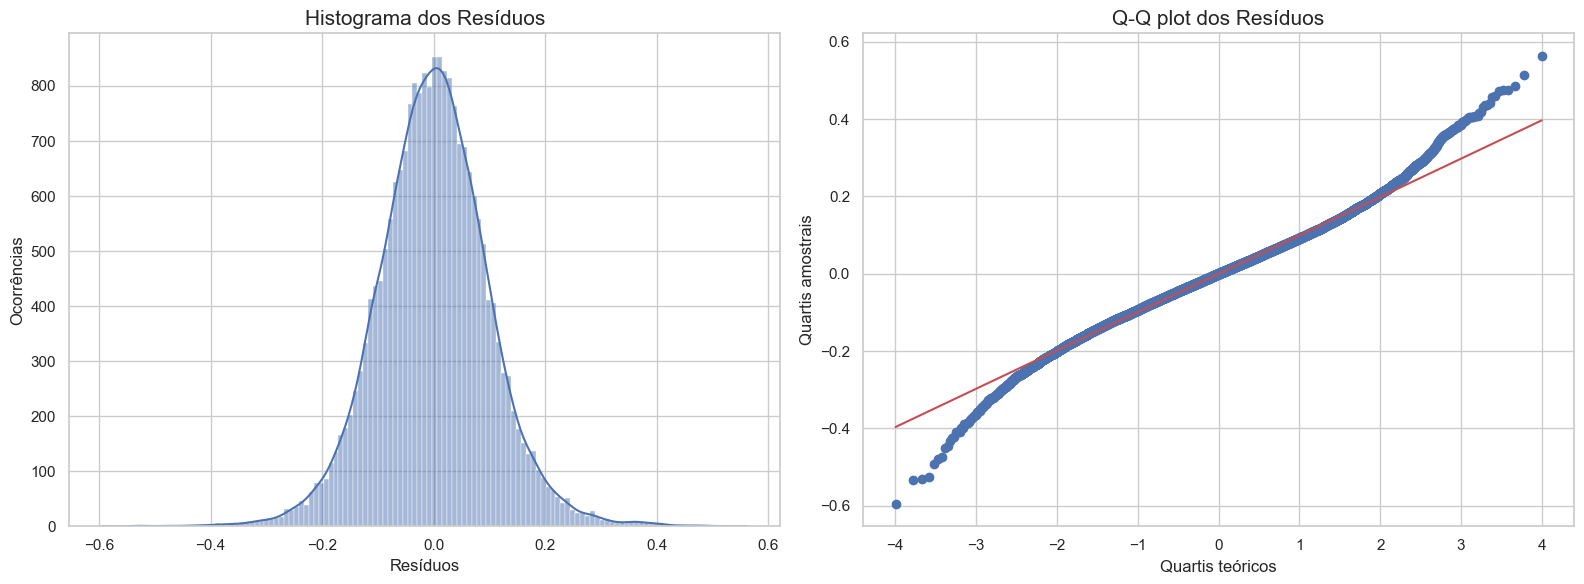

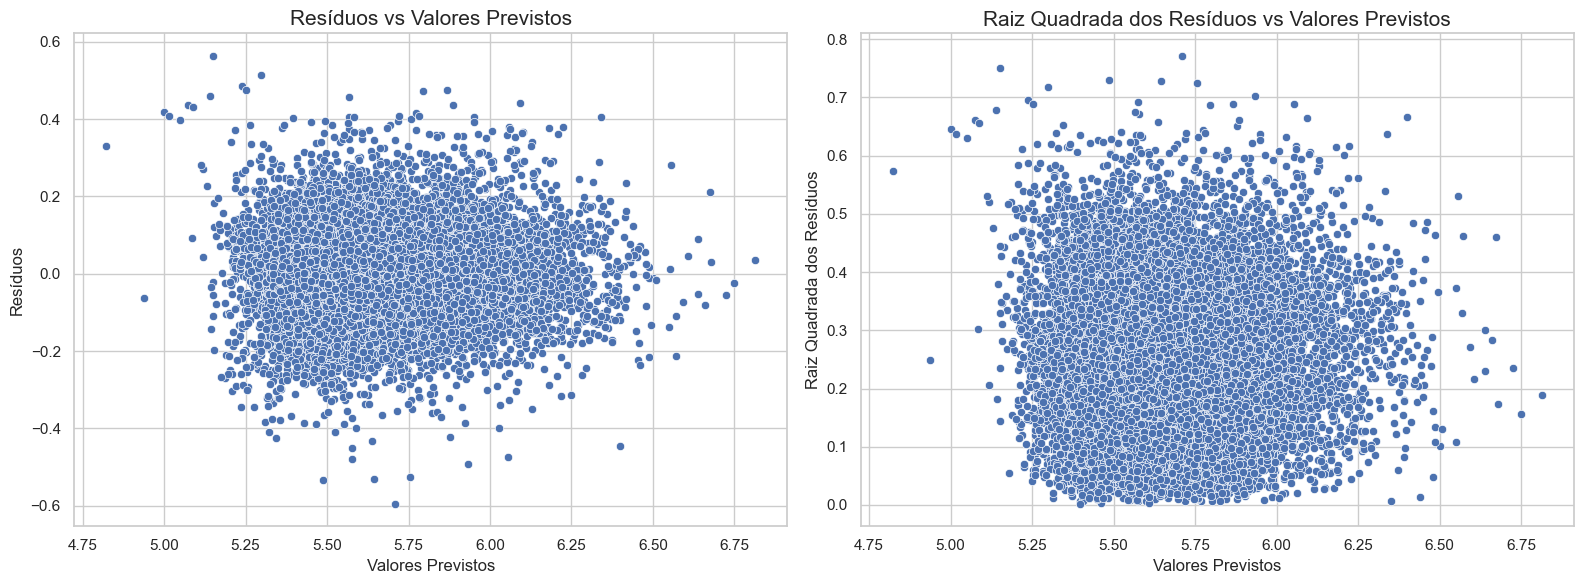

In [38]:
print('Teste de Jarque-Bera para a normalidade dos resíduos:')

jarque_bera = sm.stats.jarque_bera(lm_robusto.resid)
print(f'Estatística: {jarque_bera[0]:.4f}, p-valor: {jarque_bera[1]:.4f}')

if jarque_bera[1] > 0.05:
    print('Não rejeitamos a hipótese nula de normalidade dos resíduos.')
else:
    print('Rejeitamos a hipótese nula de normalidade dos resíduos.')

print()

print('Teste de Shapiro-Wilk para a normalidade dos resíduos:')
teste_shapiro = shapiro(lm_robusto.resid)
print(f'Estatística: {teste_shapiro[0]:.4f}, p-valor: {teste_shapiro[1]:.4f}')

if teste_shapiro[1] > 0.05:
    print(f'Não rejeitamos a hipótese nula de normalidade dos resíduos.')
else:
    print(f'Rejeitamos a hipótese nula de normalidade dos resíduos.')



fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(lm_robusto.resid, kde=True, ax=ax[0])
ax[0].set_title('Histograma dos Resíduos', fontsize=15)
ax[0].set_xlabel('Resíduos')
ax[0].set_ylabel('Ocorrências')

stats.probplot(lm_robusto.resid, dist="norm", plot=ax[1])
ax[1].set_title('Q-Q plot dos Resíduos', fontsize=15)
ax[1].set_xlabel('Quartis teóricos')
ax[1].set_ylabel('Quartis amostrais')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x=predictions, y=lm_robusto.resid, ax=ax[0])
ax[0].set_title('Resíduos vs Valores Previstos', fontsize=15)
ax[0].set_xlabel('Valores Previstos')
ax[0].set_ylabel('Resíduos')

sns.scatterplot(x=predictions, y=np.sqrt(np.abs(lm_robusto.resid)), ax=ax[1])
ax[1].set_title('Raiz Quadrada dos Resíduos vs Valores Previstos', fontsize=15)
ax[1].set_xlabel('Valores Previstos')
ax[1].set_ylabel('Raiz Quadrada dos Resíduos')

plt.tight_layout()
plt.show()

## Conclusão

Foram aplicadas transformações para log das variáveis dependentes e independentes. Além disso, foi utilizada a regressão robusta para lidar com os problemas de heterocedasticidade.

O modelo final apresentou um R² ajustado de 0.810 indicando que o modelo explica uma boa parte da variabilidade dos preços dos imóveis na região de King County. 

No entanto, ainda há problemas de normalidade dos resíduos e de multicolinearidade, o que pode afetar a validade de algumas inferências estatísticas. 

Portanto, é importante considerar essas limitações ao interpretar os resultados do modelo.

Para um modelo com maior precisão e confiabilidade, seria necessário avaliar outras técnicas de regressão, como regressão polinomial, regressão de árvore de decisão ou regressão de floresta aleatória, e realizar uma análise comparativa para identificar o modelo mais adequado para a previsão do preço dos imóveis na região de King County.

Em relação ao modelo obtido, ele pode ser utilizado como uma referência inicial para a previsão do preço dos imóveis, mas é importante considerar suas limitações. 

Além disso, ele pode ser útil para identificar as variáveis mais relevantes na determinação do preço dos imóveis e fornecer insights sobre o mercado imobiliário na região de King County.